<a href="https://colab.research.google.com/github/tsvetanov-ts/deeplearning-sentiment-analysis/blob/master/colab_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

work_dir = '/content'
project_dir = '/deeplearning-sentiment-analysis'

#os.chdir(work_dir+project_dir)


In [2]:

if os.path.exists(work_dir):
  from google.colab import userdata
  git_access_token = userdata.get('git_access_token')
  os.chdir(work_dir)
  os.mkdir(project_dir) if not os.path.exists(project_dir) else None
  !git clone https://{git_access_token}@github.com/tsvetanov-ts/deeplearning-sentiment-analysis
  os.chdir(work_dir+project_dir)

Cloning into 'deeplearning-sentiment-analysis'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 640 (delta 6), reused 17 (delta 4), pack-reused 620 (from 2)
Receiving objects: 100% (640/640), 110.47 MiB | 55.95 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
  %pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00


In [4]:
from jupyter_core.version import parts
#!pip install -r requirements.txt

In [5]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def parse_car_meta(filename):
    parts = filename.split("_")

    year = parts[0]
    brand = parts[1]
    model =  parts[2] if len(parts) == 3 else "_".join(parts[2:])

    return year, brand, model


In [7]:
base_dir = './data/cars'

In [8]:
def read_file_content(file_path):
    """Read file content with encoding error handling."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            return file.read()
    except UnicodeDecodeError:
        # Fallback to latin-1 if utf-8 fails
        with open(file_path, 'r', encoding='latin-1') as file:
            return file.read()

def extract_metadata(filename):
    """Extract and parse car metadata from soup."""
    return parse_car_meta(filename) if filename else ("Unknown", "Unknown", "Unknown") #

def process_review_document(doc, meta):
    """Process a single review document and extract its data."""
    date_tag = doc.find("date")
    author_tag = doc.find("author")
    text_tag = doc.find("text")
    favorite_tag = doc.find("favorite")

    date_str = date_tag.text if date_tag else None
    date = pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce') if date_str else None
    author = author_tag.text if author_tag else None
    text = text_tag.text if text_tag else None
    favorite = favorite_tag.text if favorite_tag else None

    return {
        "DATE": date,
        "AUTHOR": author,
        "TEXT": text,
        "FAVORITE": favorite,
        "MODEL": meta[2],
        "BRAND": meta[1],
        "YEAR_MADE": meta[0]  # Changed from "YEAR" to "YEAR_MADE"
    }

def parse_review_file(file_path):
    """Parse a review file and return a DataFrame of reviews."""
    file_content = read_file_content(file_path)

    soup = BeautifulSoup("<root>" + file_content + "</root>", 'html.parser')

    filename = os.path.basename(file_path)
    meta = extract_metadata(filename)
    docs = soup.find_all('doc')

    reviews = [process_review_document(doc, meta) for doc in docs]

    return pd.DataFrame(reviews)

In [9]:
def parse_all_reviews(base_dir='./data/cars'):
    """
    Parse all car reviews in the base directory structure.

    Args:
        base_dir (str): Base directory containing the car review files

    Returns:
        pd.DataFrame: Combined DataFrame with all reviews
    """
    dataframes = []
    total_files = 0
    total_errors = 0

    for year in os.listdir(base_dir):
        year_path = os.path.join(base_dir, year)

        if not os.path.isdir(year_path):
            continue

        print(f"Processing directory: {year}")

        for file_name in os.listdir(year_path):
            file_path = os.path.join(year_path, file_name)

            if not os.path.isfile(file_path):
                continue

            try:
                df = parse_review_file(file_path)
                dataframes.append(df)
                total_files += 1
                print(f"  Processed {file_path}: found {len(df)} reviews")

            except Exception as e:
                total_errors += 1
                print(f"  Error processing {file_path}: {str(e)}")

    if dataframes:
        # Filter out empty DataFrames before concatenation
        non_empty_dataframes = [df for df in dataframes if not df.empty]
        reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)

        if df.empty:
            empty_df_count = len(dataframes) - len(non_empty_dataframes)
            print(df)
        else:
            empty_df_count = 0


        print(f"\nTotal files processed: {total_files}")
        print(f"Total files with errors: {total_errors}")
        print(f"Total empty dataframes: {empty_df_count}")
        print(f"Total reviews extracted: {len(reviews_df)}")

        return reviews_df
    else:
        print("No review data found.")
        return pd.DataFrame()

In [10]:

reviews_df = parse_all_reviews(base_dir)

print("\nReview Data Sample:")
print(reviews_df.head())

print("\nDataFrame Info:")
print(reviews_df.info())

print("\nSummary Statistics:")
print(reviews_df.describe(include='all'))

Processing directory: 2008
  Processed ./data/cars/2008/2008_ford_f-350_super_duty: found 41 reviews
  Processed ./data/cars/2008/2008_honda_element: found 62 reviews
  Processed ./data/cars/2008/2008_mitsubishi_outlander: found 56 reviews
  Processed ./data/cars/2008/2008_chevrolet_impala: found 117 reviews
  Processed ./data/cars/2008/2008_hyundai_veracruz: found 77 reviews
  Processed ./data/cars/2008/2008_toyota_camry_solara: found 36 reviews
  Processed ./data/cars/2008/2008_infiniti_fx35: found 33 reviews
  Processed ./data/cars/2008/2008_dodge_avenger: found 115 reviews
  Processed ./data/cars/2008/2008_mini_cooper_clubman: found 26 reviews
  Processed ./data/cars/2008/2008_lexus_ls_460: found 36 reviews
  Processed ./data/cars/2008/2008_hyundai_accent: found 69 reviews
  Processed ./data/cars/2008/2008_toyota_corolla: found 62 reviews
  Processed ./data/cars/2008/2008_suzuki_forenza: found 18 reviews
  Processed ./data/cars/2008/2008_gmc_yukon_hybrid: found 14 reviews
  Process

/tmp/ipython-input-9-2891842823.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)


In [11]:
reviews_df

,DATE,AUTHOR,TEXT,FAVORITE,MODEL,BRAND,YEAR_MADE
0,2009-10-13,great truck,i have 7000 miles on the 6.4. it has lots of p...,"power,power,power",f-350_super_duty,ford,2008
1,2009-09-21,Raj,I have had this truck for almost 2 years. Till...,,f-350_super_duty,ford,2008
2,2009-08-02,used to like fords,Fuel mileage 7-9 mpg no matter if loaded or n...,When Ford recalls my truck and fixes the milea...,f-350_super_duty,ford,2008
3,2009-07-23,Sjmiller05,I want to fist say that I have the King Ranch ...,"The King Ranch interior, the ""big boy step"", a...",f-350_super_duty,ford,2008
4,2009-07-20,walker485,Have had nothing but trouble with my diesel en...,"comfort handling,bed step,",f-350_super_duty,ford,2008
...,...,...,...,...,...,...,...
42283,2008-11-07,CTM,"The Corolla S is affordable, has great styling...","Smooth engine, great MPG, excellent styling, J...",corolla,toyota,2009
42284,2008-10-31,the ole man,"Had an 08 and put 27000 on it, but the 09 is s...",The s model design.,corolla,toyota,2009
42285,2008-10-30,NinjaRob,My new Corolla S is exactly what I was looking...,"Interior design, decent sound from factory 6-s...",corolla,toyota,2009
42286,2008-10-30,Corolla Christina,I traded in a 99 Mazda Protege for a Corolla L...,"Comfortable seats, telescopic steering wheel, ...",corolla,toyota,2009


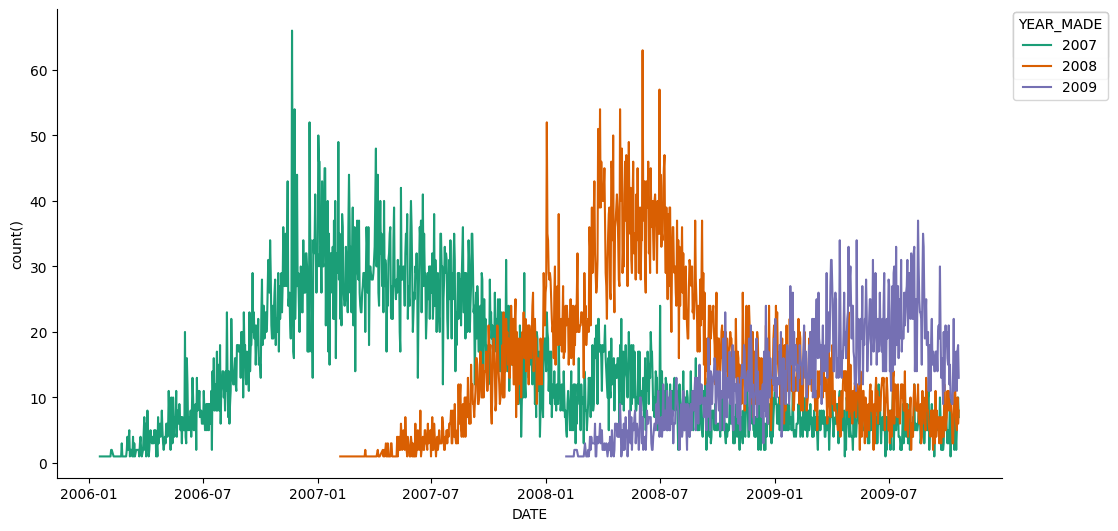

In [12]:
# @title DATE vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'DATE'}, axis=1)
              .sort_values('DATE', ascending=True))
  xs = counted['DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = reviews_df.sort_values('DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('YEAR_MADE')):
  _plot_series(series, series_name, i)
  fig.legend(title='YEAR_MADE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('count()')

In [13]:
def group_by_field(df, field, print_results=True):
    """
    Group reviews by the specified field and return the count for each group.

    Args:
        df (pd.DataFrame): DataFrame containing review data
        field (str): Field name to group by (e.g., 'YEAR', 'BRAND', 'MODEL', 'DATE')
        print_results (bool): Whether to print the results

    Returns:
        pd.Series: Count of reviews per group
    """
    if field not in df.columns:
        raise ValueError(f"Field '{field}' not found in DataFrame columns: {list(df.columns)}")

    counts = df.groupby(field).size()

    if print_results:
        print(f"Reviews per {field.lower()}:")
        print(counts)

    return counts

In [14]:
year_data = group_by_field(reviews_df, 'YEAR_MADE')
brand_data = group_by_field(reviews_df, 'BRAND')
model_data = group_by_field(reviews_df, 'MODEL')
date_data = group_by_field(reviews_df, 'DATE')

author_data = group_by_field(reviews_df, 'AUTHOR', print_results=True)

Reviews per year_made:
YEAR_MADE
2007    18903
2008    15438
2009     7947
dtype: int64
Reviews per brand:
BRAND
acura            1269
audi              637
bmw              1113
buick             504
cadillac          510
chevrolet        2864
chrysler          751
dodge            1682
ford             2775
gmc               831
honda            4570
hyundai          2502
infiniti          840
jeep             1189
kia               699
lexus             935
mazda            1819
mercedes-benz    1592
mini              196
mitsubishi        636
nissan           3003
pontiac          1086
saturn           1168
scion             700
smart             183
subaru           1015
suzuki            421
toyota           4720
volkswagen       1676
volvo             402
dtype: int64
Reviews per model:
MODEL
1_series         77
300              93
350z             58
370z             39
3_series        475
               ... 
yaris           589
yukon            98
yukon_hybrid     14
yukon_xl 

In [15]:
df = reviews_df
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[ \-]+", "_", regex=True)
      .str.replace(r"[^\w]", "", regex=True)
)

df

,date,author,text,favorite,model,brand,year_made
0,2009-10-13,great truck,i have 7000 miles on the 6.4. it has lots of p...,"power,power,power",f-350_super_duty,ford,2008
1,2009-09-21,Raj,I have had this truck for almost 2 years. Till...,,f-350_super_duty,ford,2008
2,2009-08-02,used to like fords,Fuel mileage 7-9 mpg no matter if loaded or n...,When Ford recalls my truck and fixes the milea...,f-350_super_duty,ford,2008
3,2009-07-23,Sjmiller05,I want to fist say that I have the King Ranch ...,"The King Ranch interior, the ""big boy step"", a...",f-350_super_duty,ford,2008
4,2009-07-20,walker485,Have had nothing but trouble with my diesel en...,"comfort handling,bed step,",f-350_super_duty,ford,2008
...,...,...,...,...,...,...,...
42283,2008-11-07,CTM,"The Corolla S is affordable, has great styling...","Smooth engine, great MPG, excellent styling, J...",corolla,toyota,2009
42284,2008-10-31,the ole man,"Had an 08 and put 27000 on it, but the 09 is s...",The s model design.,corolla,toyota,2009
42285,2008-10-30,NinjaRob,My new Corolla S is exactly what I was looking...,"Interior design, decent sound from factory 6-s...",corolla,toyota,2009
42286,2008-10-30,Corolla Christina,I traded in a 99 Mazda Protege for a Corolla L...,"Comfortable seats, telescopic steering wheel, ...",corolla,toyota,2009


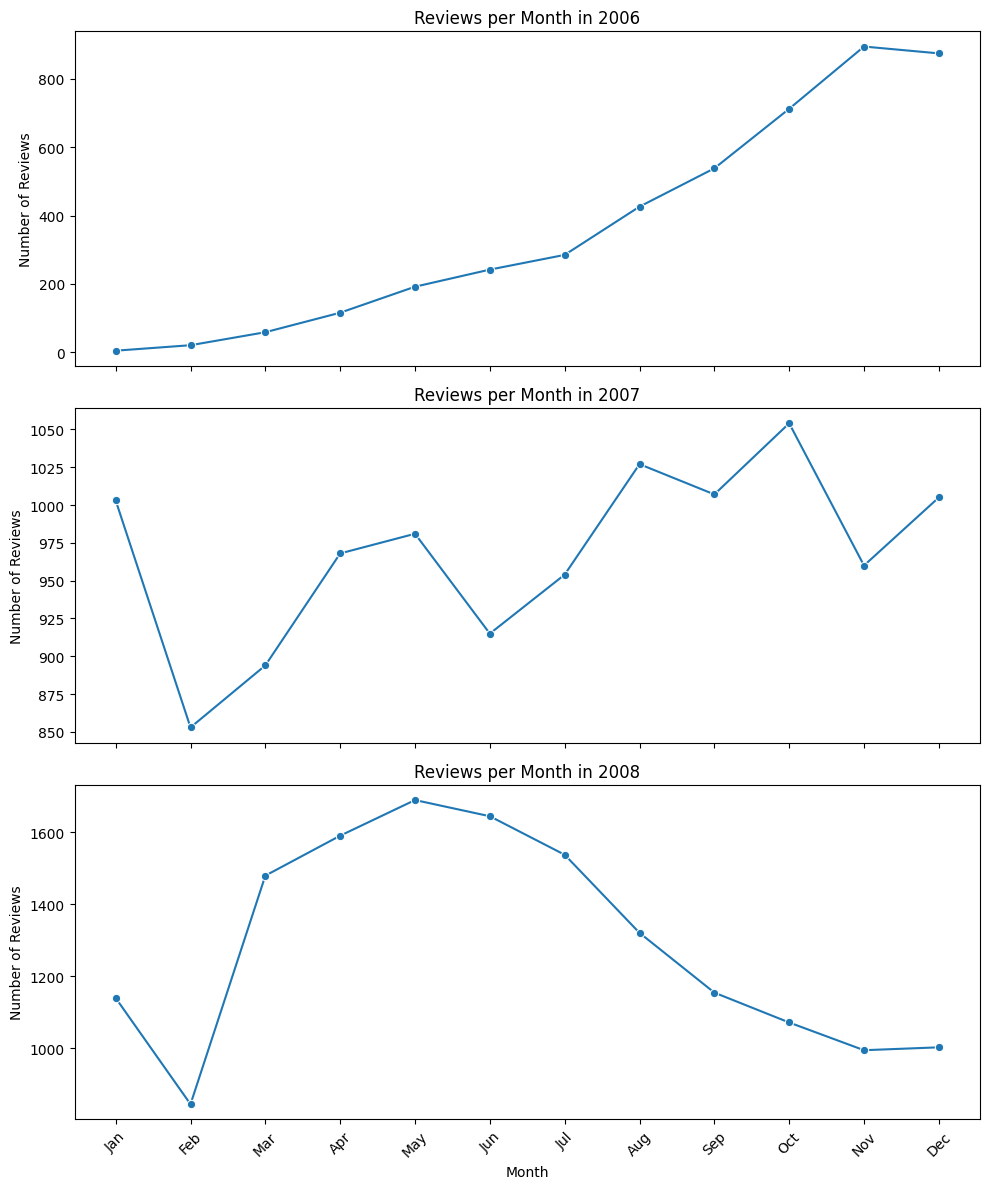

In [16]:


df['year_reviewed'] = df['date'].dt.year
df['month'] = df['date'].dt.month

counts = (
    df.groupby(['year_reviewed','month'])
      .size()
      .reset_index(name='n_reviews')
)

years = [2006, 2007, 2008, 2009, 2010] # изненадващо има ревюта и от 2006 - за коли от бъдещето...
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(10, 12),
    sharex=True
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax, year in zip(axes, years):
    data = counts[counts['year_reviewed'] == year]
    sns.lineplot(
        data=data,
        x='month', y='n_reviews',
        marker='o',
        ax=ax
    )
    ax.set_title(f'Reviews per Month in {year}')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_names, rotation=45)
    ax.set_ylabel('Number of Reviews')

axes[-1].set_xlabel('Month')

plt.tight_layout()
plt.show()

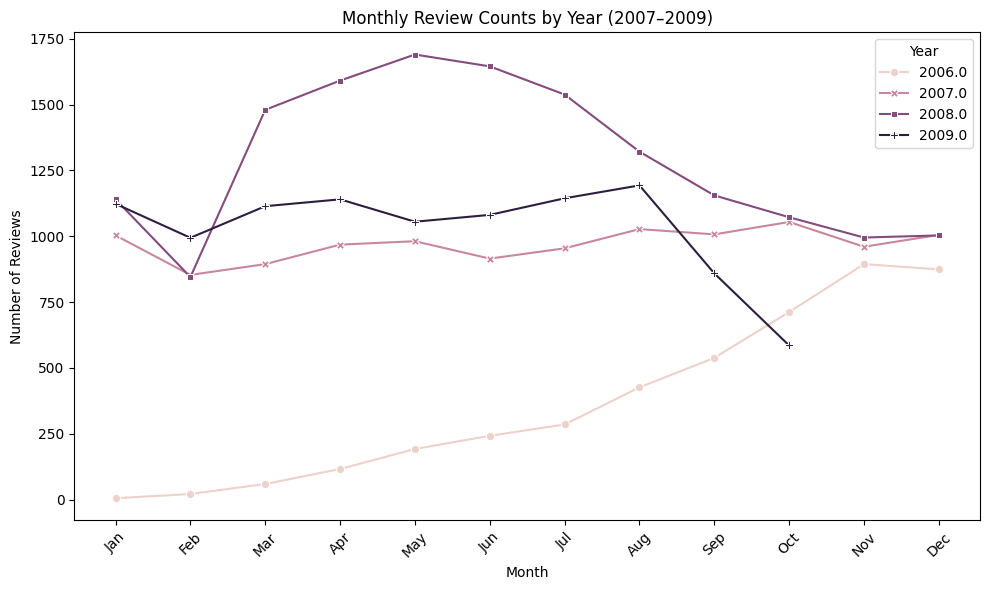

In [17]:

counts = (
    df.groupby(['year_reviewed','month'])  # Updated from 'year' to 'year_reviewed'
      .size()
      .reset_index(name='n_reviews')
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=counts,
    x='month', y='n_reviews',
    hue='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    style='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    markers=True,
    dashes=False
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(1,13), labels=month_names, rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Counts by Year (2007–2009)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

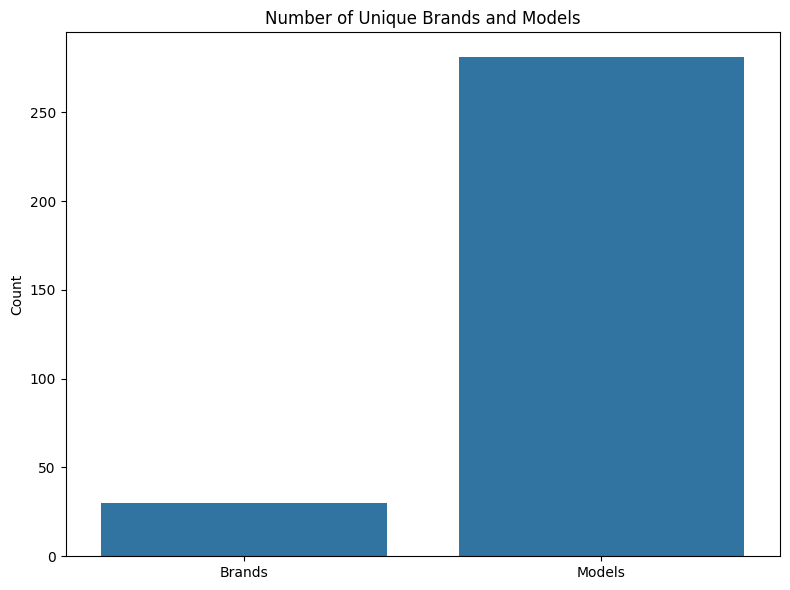

In [18]:
brand_count = df['brand'].nunique()
model_count = df['model'].nunique()

categories = ['Brands', 'Models']
counts = [brand_count, model_count]

plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts)
plt.title('Number of Unique Brands and Models')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

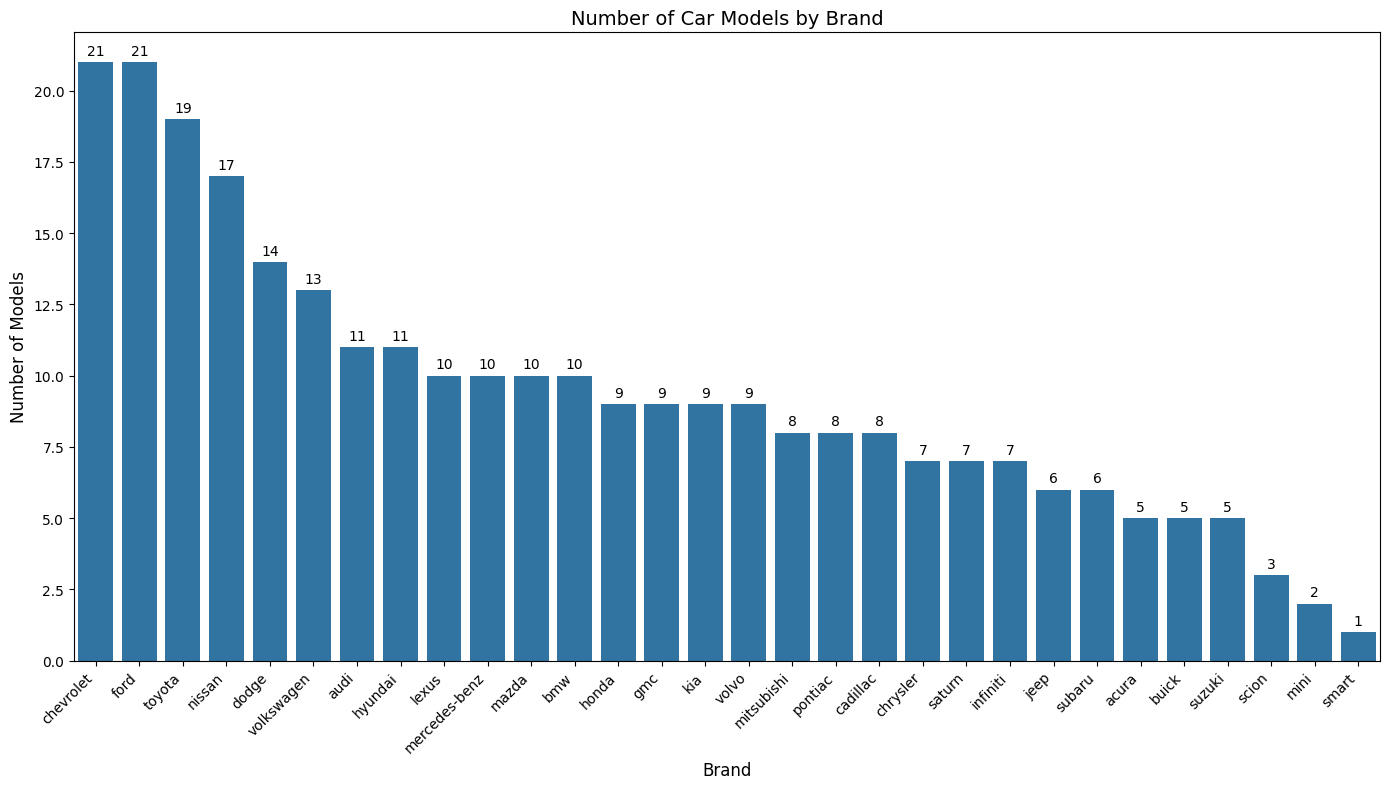

In [19]:
models_by_brand = df.groupby('brand')['model'].nunique().reset_index()
models_by_brand.columns = ['Brand', 'Number of Models']

models_by_brand = models_by_brand.sort_values('Number of Models', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=models_by_brand, x='Brand', y='Number of Models')

plt.title('Number of Car Models by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = models_by_brand.iloc[i]['Number of Models']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

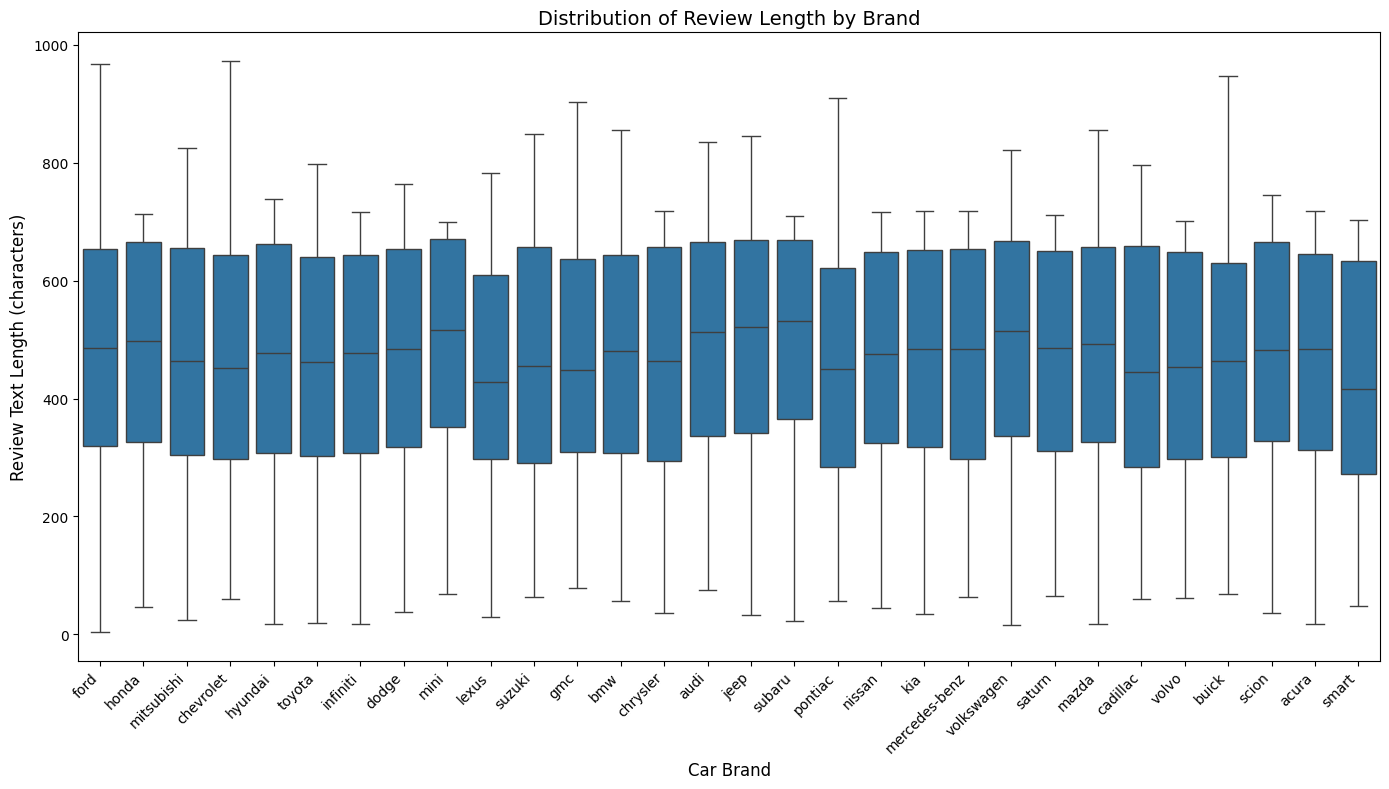

In [20]:
df['text_len'] = df['text'].str.len()

plt.figure(figsize=(14, 8))

ax = sns.boxplot(data=df, x='brand', y='text_len')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Car Brand', fontsize=12)
plt.ylabel('Review Text Length (characters)', fontsize=12)
plt.title("Distribution of Review Length by Brand", fontsize=14)

plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

plt.show()

In [21]:
null_rows = df[df.isna().any(axis=1)]
print(f"Number of rows with null values: {len(null_rows)}")
display(null_rows)

empty_text_rows = df[(df['text'] == '') |
                     (df['author'] == '') |
                     (df['favorite'] == '')]
print(f"Number of rows with empty text fields: {len(empty_text_rows)}")
display(empty_text_rows)

Number of rows with null values: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
10930,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10931,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10932,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10933,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10934,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11465,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11466,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11467,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11468,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Number of rows with empty text fields: 1631


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
1,2009-09-21,Raj,I have had this truck for almost 2 years. Till...,,f-350_super_duty,ford,2008,2009.0,9.0,216.0
159,2009-09-07,Bob Riehm,Just turned in my 2007 Impala SS. It was a fan...,,impala,chevrolet,2008,2009.0,9.0,636.0
167,2009-05-17,puffrooster,Originally I set out to buy an loaded LTZ with...,,impala,chevrolet,2008,2009.0,5.0,555.0
207,2009-01-26,Bill B,Bought vehicle 11/08. Was a rental car so a fe...,,impala,chevrolet,2008,2009.0,1.0,523.0
224,2008-09-17,Jeanne,"I thought I was buying a good car, but it is b...",,impala,chevrolet,2008,2008.0,9.0,293.0
...,...,...,...,...,...,...,...,...,...,...
42180,2009-07-25,HLB,This is my third Toyota Corolla. We have also ...,,corolla,toyota,2009,2009.0,7.0,395.0
42232,2009-05-20,Peter,"Plain and simple, the new Corolla is a well-bu...",,corolla,toyota,2009,2009.0,5.0,391.0
42233,2009-05-20,Jerseygirl,I'd like to know where the people who claim th...,,corolla,toyota,2009,2009.0,5.0,353.0
42242,2009-04-23,Don,"Purchased car to save mileage, have SUV for wi...",,corolla,toyota,2009,2009.0,4.0,199.0


In [22]:
date_missing = df[df['date'].isna()]
print(f"Number of rows with missing dates: {len(date_missing)}")
display(date_missing)

df_filtered = df.dropna(subset=['date'])
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_filtered.shape}")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} rows with missing dates")

Number of rows with missing dates: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
10930,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10931,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10932,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10933,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
10934,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11465,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11466,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11467,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
11468,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Original dataframe shape: (42288, 10)
Filtered dataframe shape: (41748, 10)
Removed 540 rows with missing dates


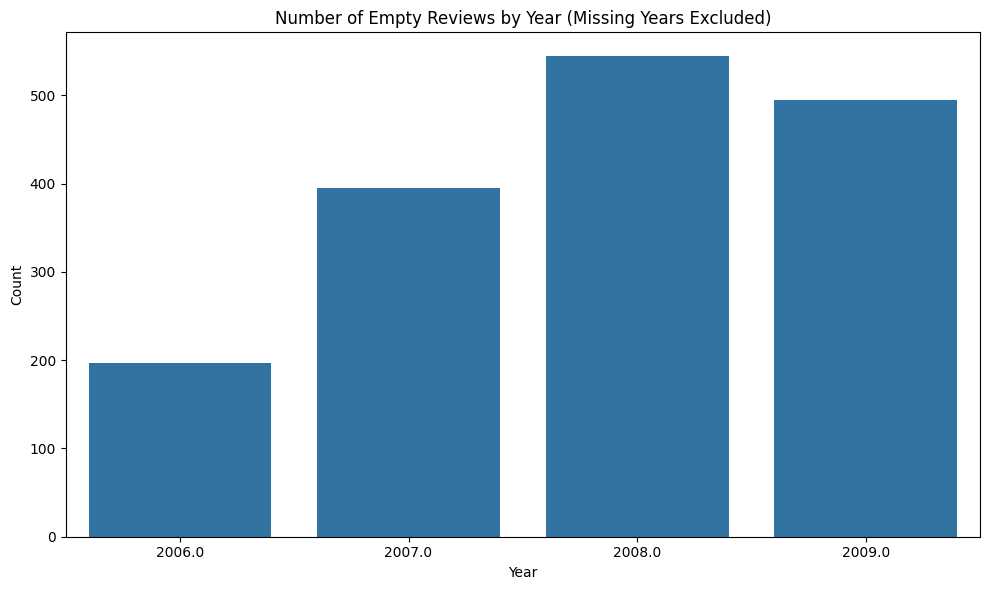

In [23]:
empty_reviews = df[(df.isna().any(axis=1)) |
                   (df['text'] == '') |
                   (df['author'] == '') |
                   (df['favorite'] == '')]

empty_reviews_filtered = empty_reviews.dropna(subset=['year_reviewed']).copy()

empty_by_year = empty_reviews_filtered.groupby('year_reviewed').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=empty_by_year, x='year_reviewed', y='count')
plt.title('Number of Empty Reviews by Year (Missing Years Excluded)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Average reviews per day: 31.04


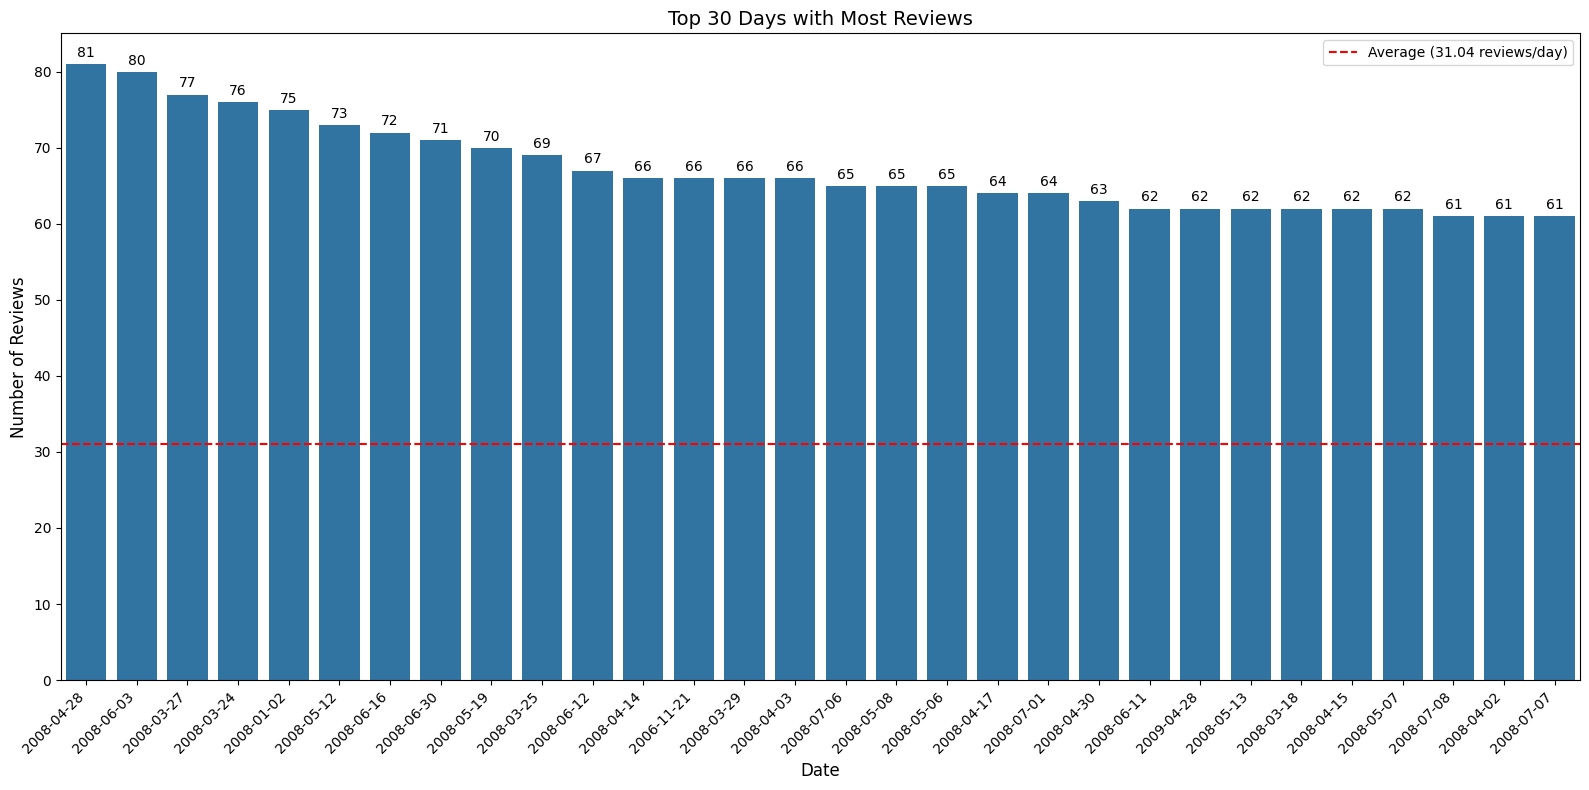

In [24]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

avg_reviews_per_day = reviews_per_day['reviews'].mean()
print(f"Average reviews per day: {avg_reviews_per_day:.2f}")


top_30_days = reviews_per_day.sort_values('reviews', ascending=False).head(30)

plt.figure(figsize=(16, 8))  # Larger figure to fit more bars
ax = sns.barplot(data=top_30_days, x='date', y='reviews')

ax.axhline(y=avg_reviews_per_day, color='r', linestyle='--',
           label=f'Average ({avg_reviews_per_day:.2f} reviews/day)')


plt.title('Top 30 Days with Most Reviews', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

for i, bar in enumerate(ax.patches):
    count = top_30_days.iloc[i]['reviews']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

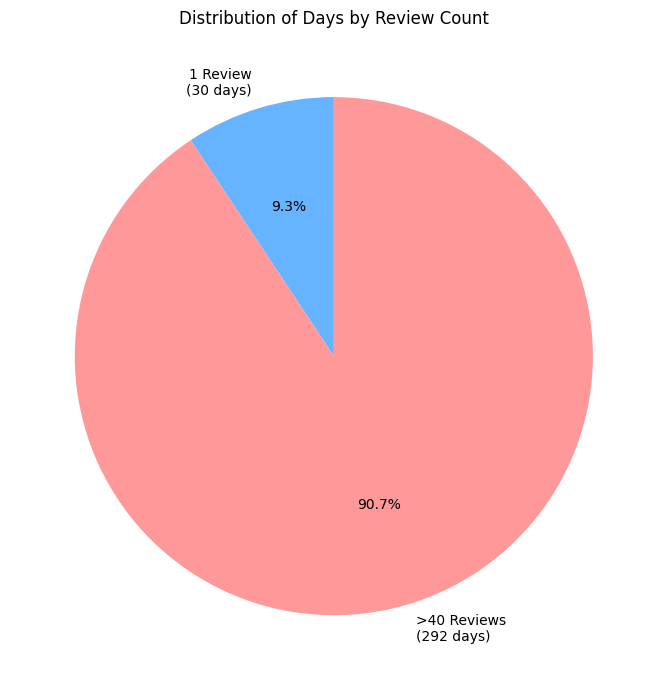

In [25]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] == 1).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 40).sum()

categories = ['1 Review', '>40 Reviews']
counts = [days_with_1_review, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

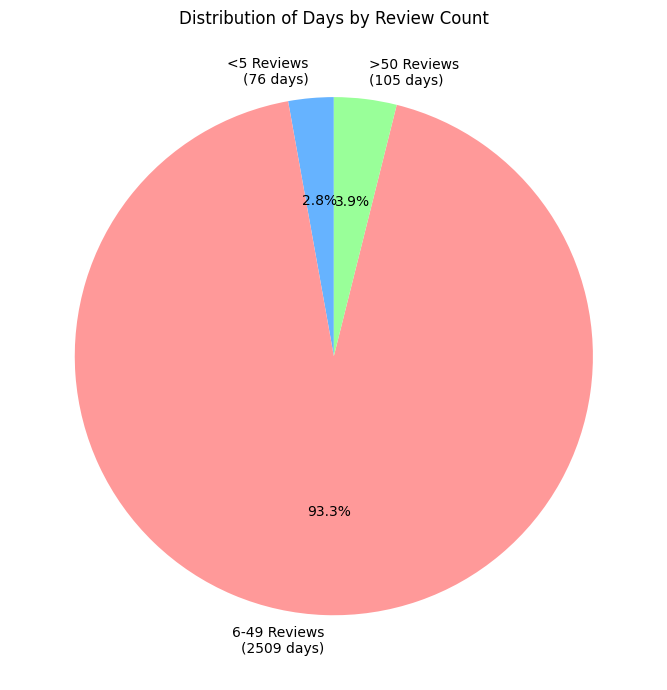

In [26]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] < 5).sum()
days_in_between = (reviews_per_day['reviews'] >= 5).sum() + (reviews_per_day['reviews'] <= 50).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 50).sum()

categories = ['<5 Reviews', '6-49 Reviews', '>50 Reviews']
counts = [days_with_1_review, days_in_between, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999', '#99ff99']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

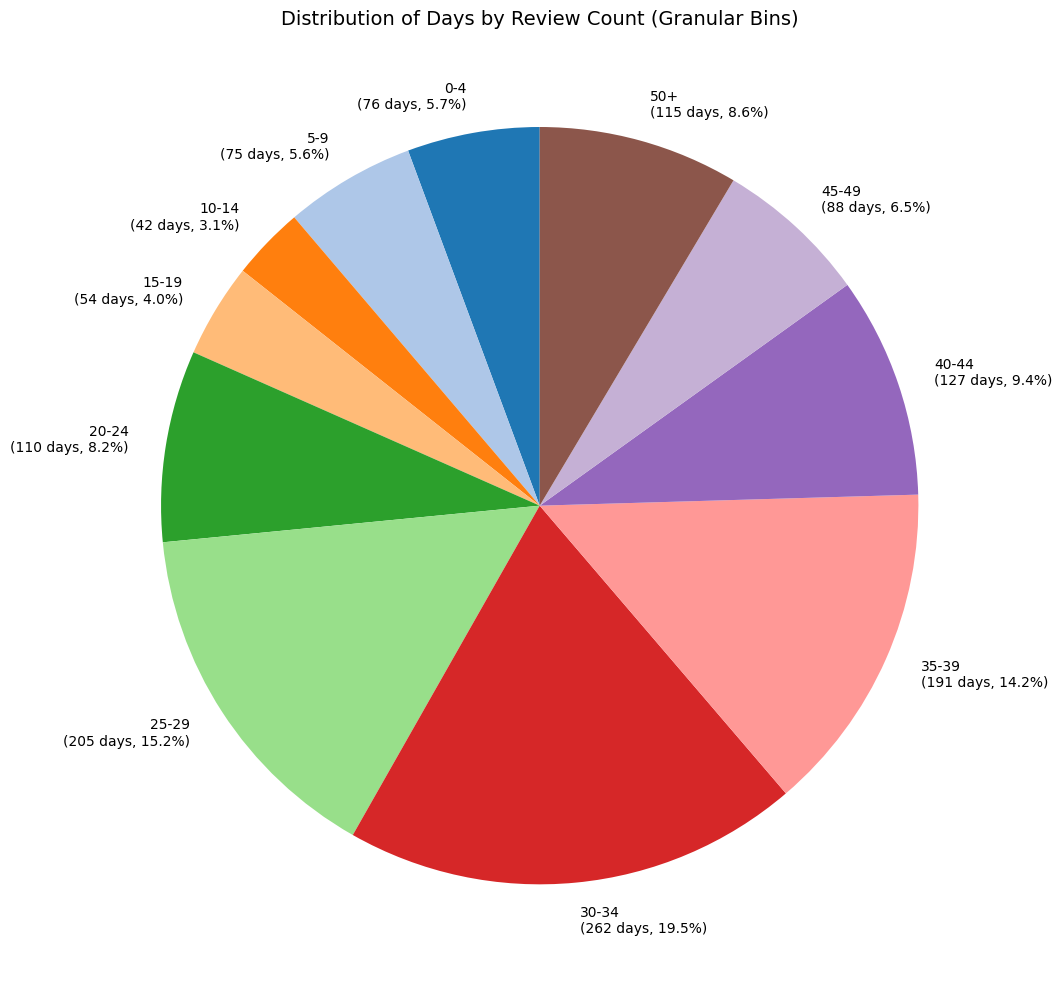

Distribution of days by review count:
0-4 reviews: 76 days (5.7%)
5-9 reviews: 75 days (5.6%)
10-14 reviews: 42 days (3.1%)
15-19 reviews: 54 days (4.0%)
20-24 reviews: 110 days (8.2%)
25-29 reviews: 205 days (15.2%)
30-34 reviews: 262 days (19.5%)
35-39 reviews: 191 days (14.2%)
40-44 reviews: 127 days (9.4%)
45-49 reviews: 88 days (6.5%)
50+ reviews: 115 days (8.6%)


In [27]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, float('inf')]
bin_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50+']

binned_reviews = pd.cut(reviews_per_day['reviews'], bins=bins, labels=bin_labels, right=True)
day_counts = binned_reviews.value_counts().sort_index()

pie_data = pd.DataFrame({'bin': day_counts.index, 'count': day_counts.values})

total_days = pie_data['count'].sum()
pie_data['percentage'] = (pie_data['count'] / total_days * 100).round(1)

pie_data['label'] = pie_data.apply(
    lambda x: f"{x['bin']}\n({x['count']} days, {x['percentage']}%)",
    axis=1
)

plt.figure(figsize=(12, 10))
plt.pie(
    pie_data['count'],
    labels=pie_data['label'],
    autopct='',  # Using custom labels instead
    startangle=90,
    colors=plt.cm.tab20.colors[:len(pie_data)]
)
plt.title('Distribution of Days by Review Count (Granular Bins)', fontsize=14)
plt.tight_layout()
plt.show()

# Display the actual counts in a table
print("Distribution of days by review count:")
for idx, row in pie_data.iterrows():
    print(f"{row['bin']} reviews: {row['count']} days ({row['percentage']}%)")


Top 6 brands by review count: ['toyota', 'honda', 'nissan', 'chevrolet', 'ford', 'hyundai']


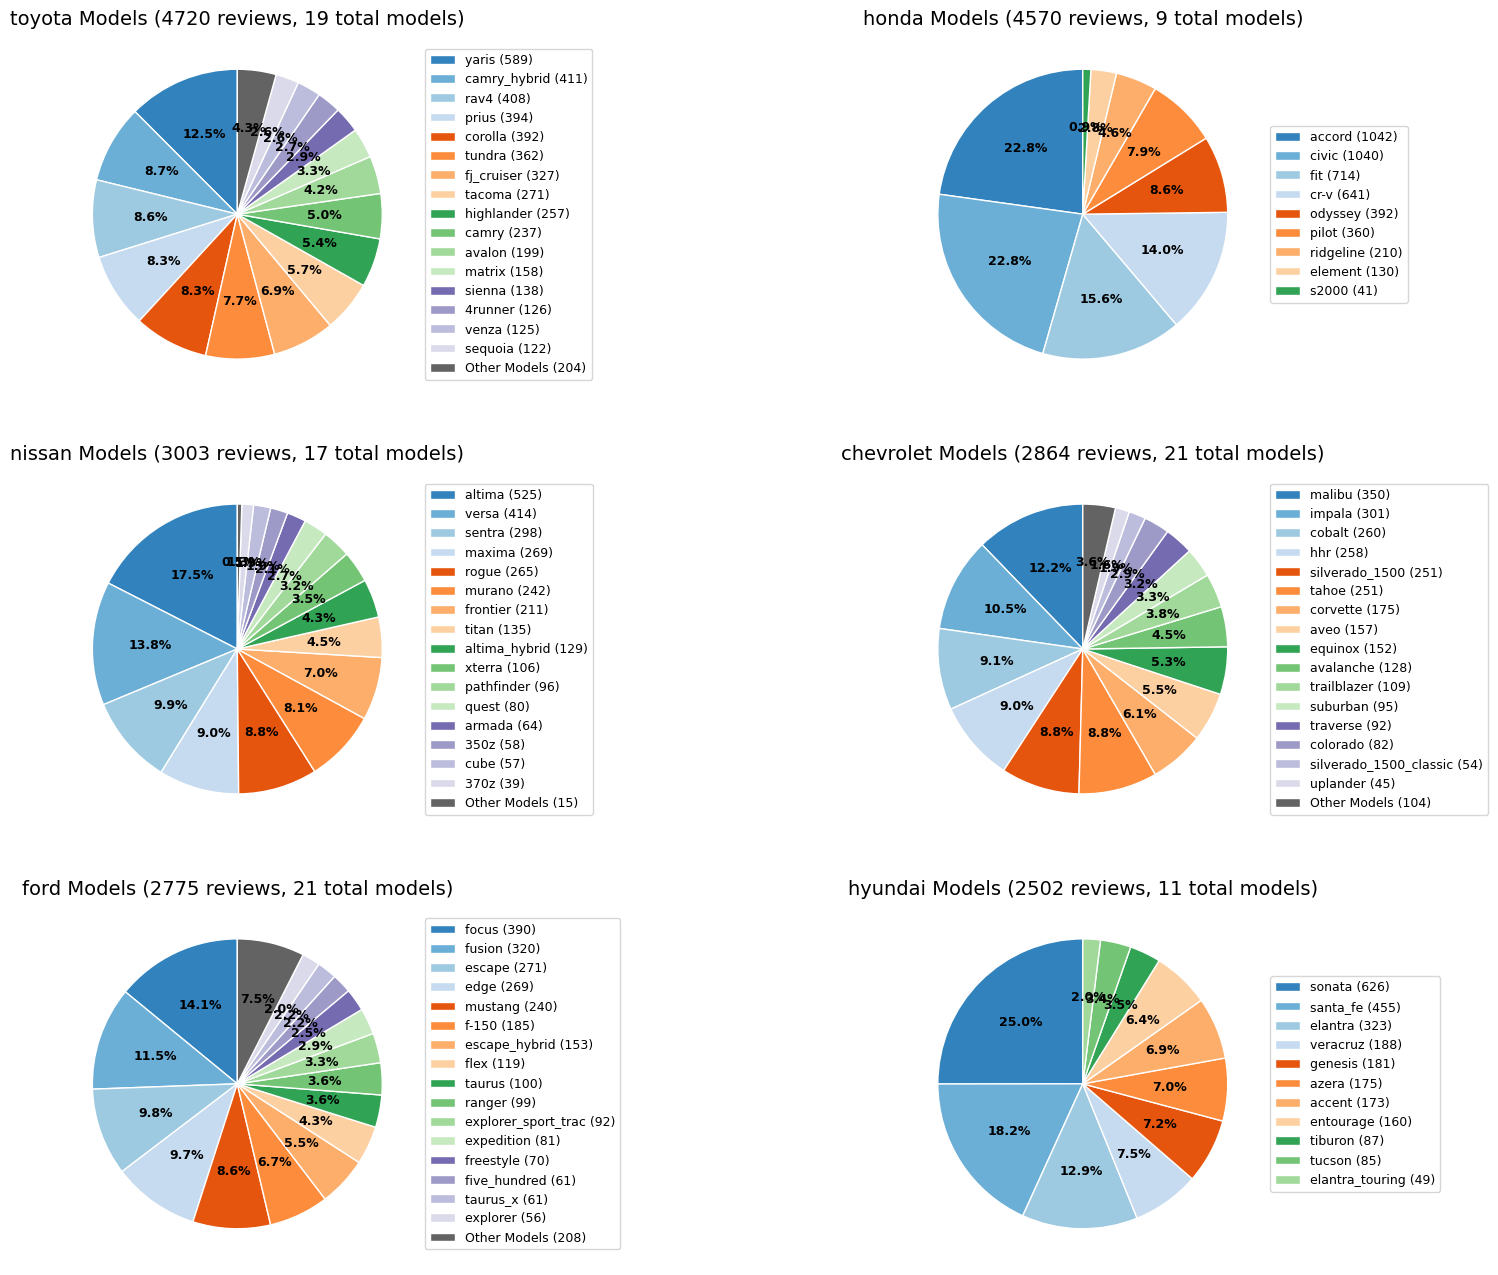

In [28]:
top_brands = df['brand'].value_counts().head(6).index.tolist()
print(f"Top 6 brands by review count: {top_brands}")

fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier iteration

for i, brand in enumerate(top_brands):
    brand_data = df[df['brand'] == brand]

    model_counts = brand_data['model'].value_counts()
    total_reviews = model_counts.sum()
    num_models = len(model_counts)

    N = 16
    if len(model_counts) > N:
        top_models = model_counts.head(N)
        other_count = model_counts[N:].sum()
        plot_data = pd.concat([top_models, pd.Series({'Other Models': other_count})])
    else:
        plot_data = model_counts

    ax = axes[i]
    wedges, texts, autotexts = ax.pie(
        plot_data.values,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20c.colors[:len(plot_data)],
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)

    ax.set_title(f'{brand} Models ({total_reviews} reviews, {num_models} total models)', fontsize=14)

    legend_labels = [f"{model} ({count})" for model, count in zip(plot_data.index, plot_data.values)]
    ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.show()


Number of unique favorites: 38571

Top favorites and their counts:


,Favorite,Count
0,,1631
1,Suggested Improvements,69
2,Everything,61
3,None,44
4,Everything.,31
5,Everything!,28
6,Gas mileage,27
7,none,22
8,Written by:,17
9,everything,16


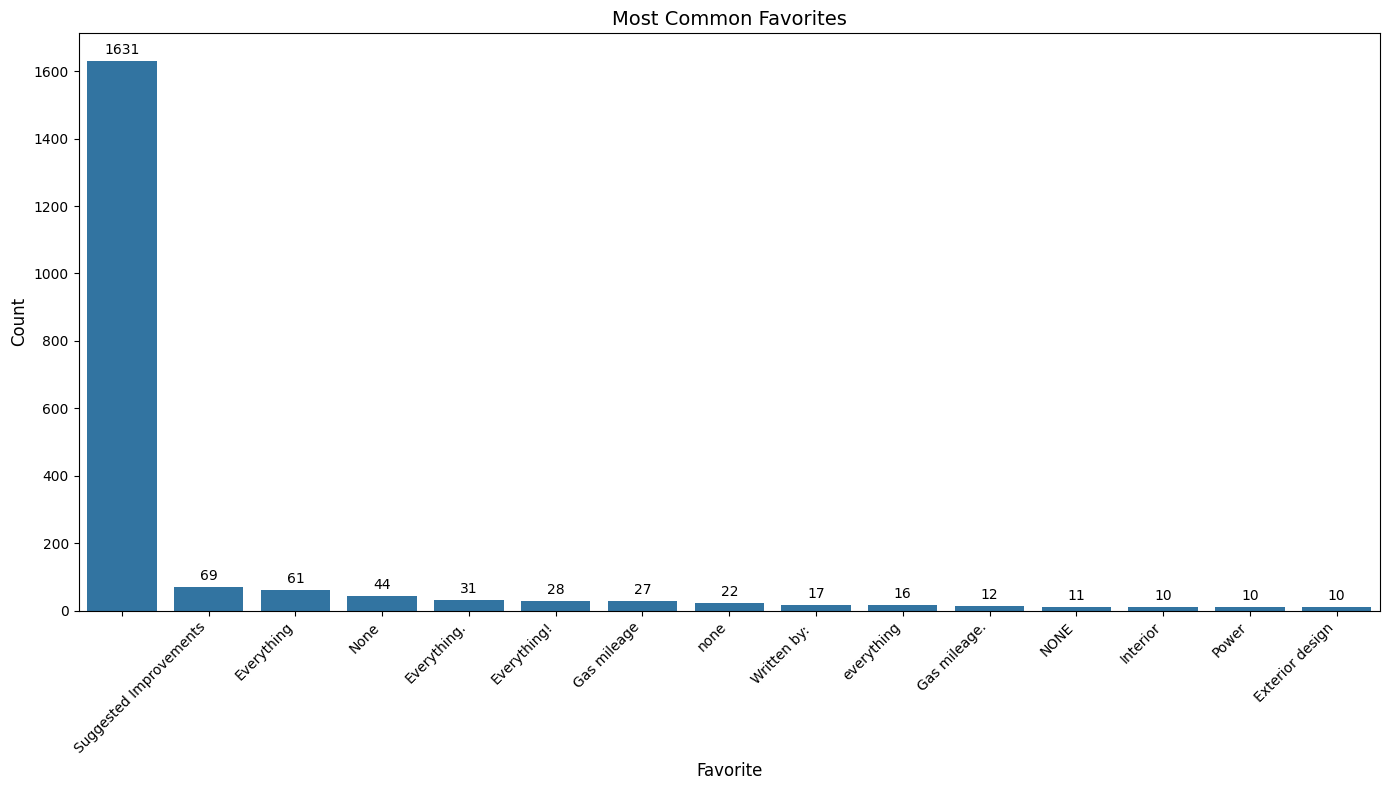

In [29]:

unique_favorites_count = df['favorite'].nunique()
print(f"Number of unique favorites: {unique_favorites_count}")

favorite_counts = df['favorite'].value_counts().reset_index()
favorite_counts.columns = ['Favorite', 'Count']

print("\nTop favorites and their counts:")
display(favorite_counts.head(10))  # Show top 10 favorites

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=favorite_counts.head(15), x='Favorite', y='Count')
plt.title('Most Common Favorites', fontsize=14)
plt.xlabel('Favorite', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = favorite_counts.iloc[i]['Count']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-2458066276.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
/tmp/ipython-input-30-2458066276.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')


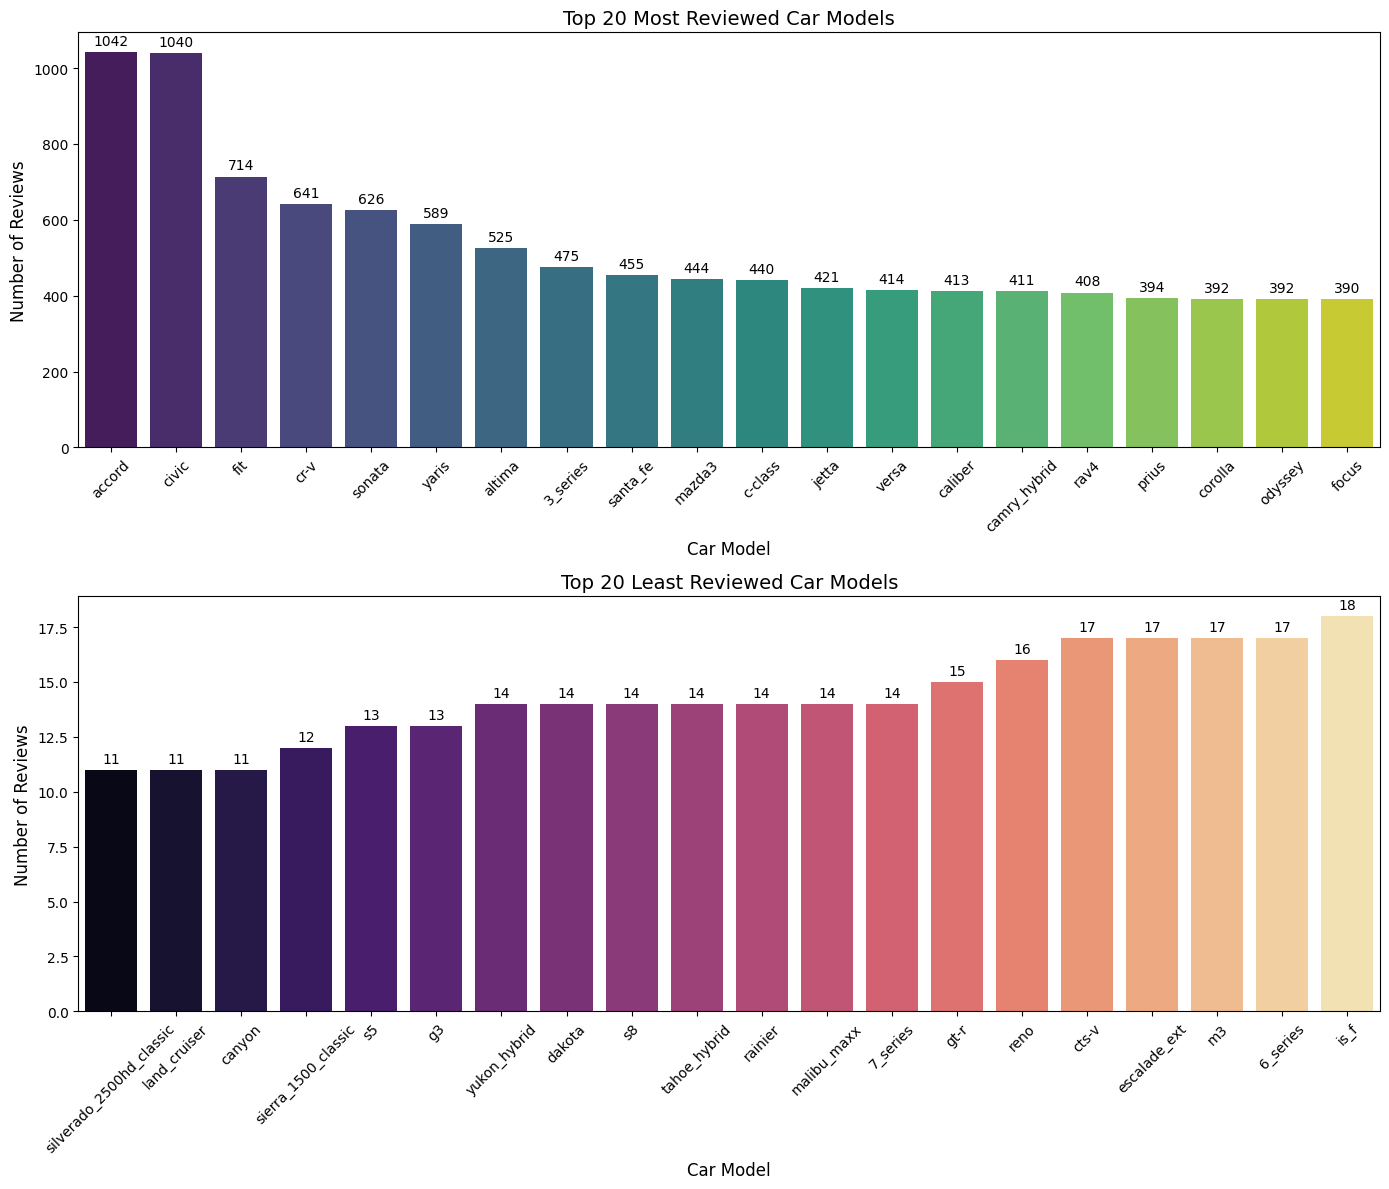

In [30]:
model_review_counts = df.groupby('model').size().reset_index(name='count')

most_reviewed = model_review_counts.sort_values('count', ascending=False).head(20)
least_reviewed = model_review_counts.sort_values('count').head(20)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Reviewed Car Models', fontsize=14)
axes[0].set_xlabel('Car Model', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[0].patches):
    count = most_reviewed.iloc[i]['count']
    axes[0].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')
axes[1].set_title('Top 20 Least Reviewed Car Models', fontsize=14)
axes[1].set_xlabel('Car Model', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[1].patches):
    count = least_reviewed.iloc[i]['count']
    axes[1].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [31]:
model_counts = df.groupby('model').size().sort_values(ascending=False)
print("Unique Car Models with Review Counts:")
print("====================================")
for model, count in model_counts.items():
    print(f"{model}: {count}")

print(f"\nTotal unique models: {len(model_counts)}")

Unique Car Models with Review Counts:
accord: 1042
civic: 1040
fit: 714
cr-v: 641
sonata: 626
yaris: 589
altima: 525
3_series: 475
santa_fe: 455
mazda3: 444
c-class: 440
jetta: 421
versa: 414
caliber: 413
camry_hybrid: 411
rav4: 408
prius: 394
corolla: 392
odyssey: 392
focus: 390
acadia: 388
tl: 371
tundra: 362
pilot: 360
malibu: 350
aura: 331
cx-7: 331
fj_cruiser: 327
wrangler: 327
elantra: 323
g35: 320
fusion: 320
mdx: 315
impala: 301
sentra: 298
vue: 296
g6: 286
xb: 275
tacoma: 271
escape: 271
edge: 269
maxima: 269
patriot: 267
tsx: 266
rogue: 265
impreza: 265
cx-9: 265
rdx: 263
forester: 260
cobalt: 260
enclave: 259
passat: 259
hhr: 258
mazda6: 258
highlander: 257
silverado_1500: 251
tahoe: 251
e-class: 242
rabbit: 242
murano: 242
mustang: 240
5_series: 239
camry: 237
g8: 236
tc: 232
es_350: 226
a4: 223
outlander: 222
m-class: 222
cts: 219
gl-class: 214
frontier: 211
ridgeline: 210
ram_pickup_1500: 209
town_and_country: 207
outlook: 206
avalon: 199
outback: 198
xd: 193
mazda5: 191


In [32]:
import re
import nltk
import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
vader = SentimentIntensityAnalyzer()


def clean_text(text):
    """Clean and normalize text data."""
    if not isinstance(text, str) or pd.isna(text):
        return ""

    text = text.lower()

    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text


def preprocess_text(text):
    """Tokenize, remove stopwords, and lemmatize text."""
    if not text:
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


def extract_features(row):
    """Extract features from text fields."""
    text = clean_text(row['text']) if isinstance(row['text'], str) else ""
    favorite = clean_text(row['favorite']) if isinstance(row['favorite'], str) else ""

    text_length = len(text)
    text_word_count = len(text.split()) if text else 0

    processed_tokens = preprocess_text(text)

    vader_scores = vader.polarity_scores(text) if text else {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

    tb = TextBlob(text)
    tb_polarity = tb.sentiment.polarity if text else 0
    tb_subjectivity = tb.sentiment.subjectivity if text else 0

    has_price_mention = 1 if re.search(r'price|cost|expensive|cheap|afford', text) else 0
    has_performance_mention = 1 if re.search(r'speed|fast|slow|acceleration|horsepower|hp|mpg', text) else 0
    has_comfort_mention = 1 if re.search(r'comfort|seat|space|room|leg|interior', text) else 0
    has_reliability_mention = 1 if re.search(r'reliable|dependable|quality|problem|issue|break', text) else 0

    return {
        'text_length': text_length,
        'word_count': text_word_count,
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'vader_positive': vader_scores['pos'],
        'vader_compound': vader_scores['compound'],
        'textblob_polarity': tb_polarity,
        'textblob_subjectivity': tb_subjectivity,
        'has_price_mention': has_price_mention,
        'has_performance_mention': has_performance_mention,
        'has_comfort_mention': has_comfort_mention,
        'has_reliability_mention': has_reliability_mention,
        'cleaned_text': ' '.join(processed_tokens)
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Enriched DataFrame with text features:

Sentiment Analysis Statistics:
       vader_compound  textblob_polarity  textblob_subjectivity
count    42288.000000       42288.000000           42288.000000
mean         0.697473           0.240383               0.524715
std          0.476069           0.174218               0.133011
min         -0.992000          -1.000000               0.000000
25%          0.717200           0.137396               0.454859
50%          0.911700           0.243242               0.528175
75%          0.963200           0.345844               0.602246
max          0.997700           1.000000               1.000000


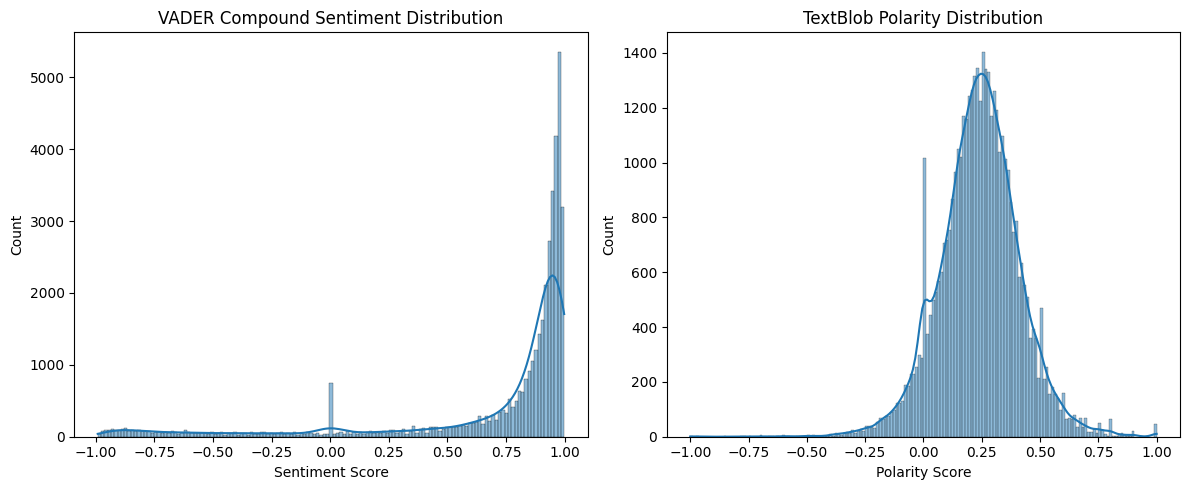

In [33]:
feature_data = df.apply(extract_features, axis=1)

features_df = pd.DataFrame(feature_data.tolist())

df_enriched = pd.concat([df, features_df], axis=1)

print("Enriched DataFrame with text features:")
var = df_enriched.sample(5)[['model', 'brand', 'text_length', 'word_count',
                             'vader_compound', 'textblob_polarity', 'has_performance_mention']]

print("\nSentiment Analysis Statistics:")
print(df_enriched[['vader_compound', 'textblob_polarity', 'textblob_subjectivity']].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_enriched['vader_compound'], kde=True)
plt.title('VADER Compound Sentiment Distribution')
plt.xlabel('Sentiment Score')

plt.subplot(1, 2, 2)
sns.histplot(df_enriched['textblob_polarity'], kde=True)
plt.title('TextBlob Polarity Distribution')
plt.xlabel('Polarity Score')

plt.tight_layout()
plt.show()

In [56]:
#%pip install scikit-learn==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0


Distribution of sentiment labels:
sentiment_label
positive    37065
negative     3867
neutral      1356
Name: count, dtype: int64


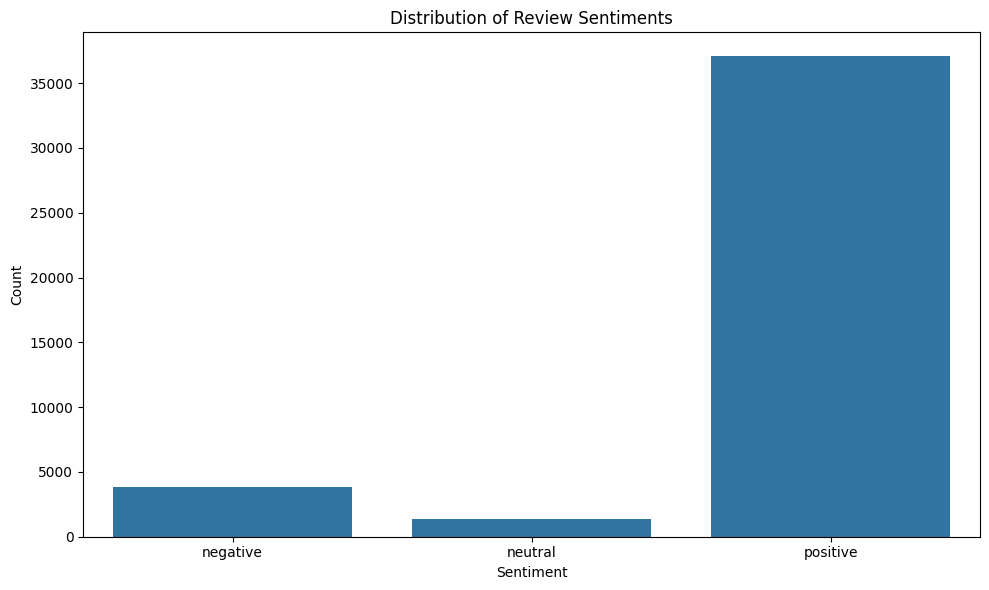

Training set size: 33398
Testing set size: 8350


In [34]:
# Implement Bag of Words + Naive Bayes for sentiment classification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np

# First, let's create sentiment labels based on the vader_compound score
# This is a common approach for creating discrete sentiment classes
df_enriched['sentiment_label'] = pd.cut(
    df_enriched['vader_compound'],
    bins=[-1, -0.1, 0.1, 1],
    labels=['negative', 'neutral', 'positive']
)

# Check the distribution of sentiment labels
sentiment_distribution = df_enriched['sentiment_label'].value_counts()
print("Distribution of sentiment labels:")
print(sentiment_distribution)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df_enriched)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Prepare data for classification
# We'll use cleaned_text which was already preprocessed
X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

# Remove rows with empty text or NaN values
valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Bag of Words + Naive Bayes Results:
Accuracy: 0.8932934131736527

Classification Report:
              precision    recall  f1-score   support

    negative       0.51      0.71      0.59       774
     neutral       0.05      0.02      0.03       163
    positive       0.96      0.93      0.94      7413

    accuracy                           0.89      8350
   macro avg       0.51      0.55      0.52      8350
weighted avg       0.90      0.89      0.89      8350



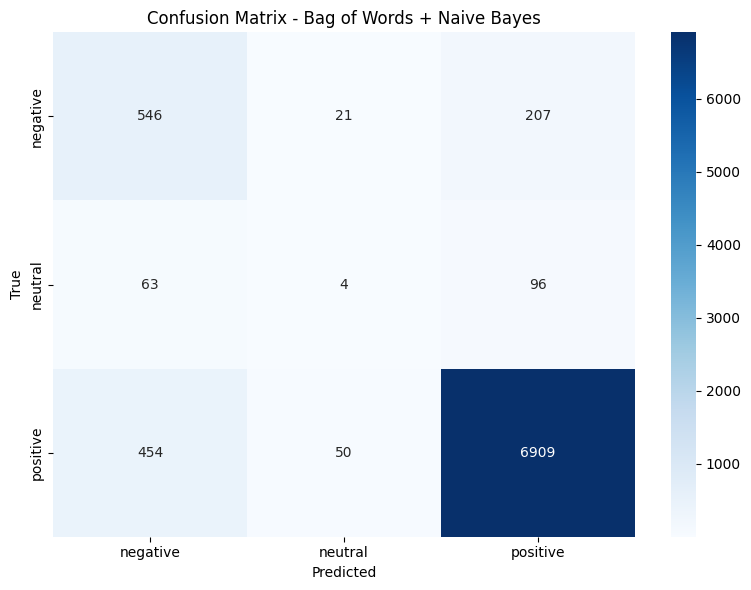

In [35]:
# Create a pipeline with Bag of Words and Naive Bayes
# First approach: Simple CountVectorizer
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

# Train the model
bow_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bow_pipeline.predict(X_test)

# Evaluate the model
print("\nBag of Words + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Bag of Words + Naive Bayes')
plt.tight_layout()
plt.show()



TF-IDF + Naive Bayes Results:
Accuracy: 0.9082634730538922

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.37      0.48       774
     neutral       0.00      0.00      0.00       163
    positive       0.92      0.98      0.95      7413

    accuracy                           0.91      8350
   macro avg       0.53      0.45      0.48      8350
weighted avg       0.88      0.91      0.89      8350



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


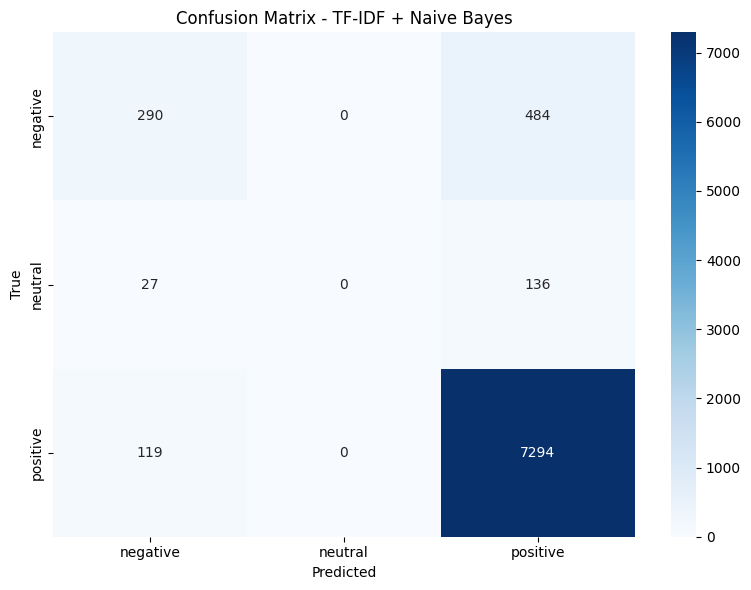

In [36]:
# Let's try a more advanced approach: TF-IDF + Naive Bayes with n-grams
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Include both unigrams and bigrams
        min_df=5  # Minimum document frequency
    )),
    ('classifier', MultinomialNB())
])

# Train the model
tfidf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_tfidf = tfidf_pipeline.predict(X_test)

# Evaluate the model
print("\nTF-IDF + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

# Display confusion matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF + Naive Bayes')
plt.tight_layout()
plt.show()


In [37]:
# Implementing Logistic Regression with Bag of Words and TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

print("Implementing Logistic Regression models and comparing with Naive Bayes...")

# Ensure we're using the same data as before
X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

# Remove rows with empty text or NaN values
valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

# Use the same train/test split for fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a results dictionary to store performance metrics
model_results = {}


Implementing Logistic Regression models and comparing with Naive Bayes...



1. Training Bag of Words + Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training completed in 3.62 seconds

Bag of Words + Logistic Regression Results:
Accuracy: 0.9262

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67       774
     neutral       0.15      0.04      0.06       163
    positive       0.95      0.98      0.96      7413

    accuracy                           0.93      8350
   macro avg       0.60      0.55      0.56      8350
weighted avg       0.91      0.93      0.92      8350



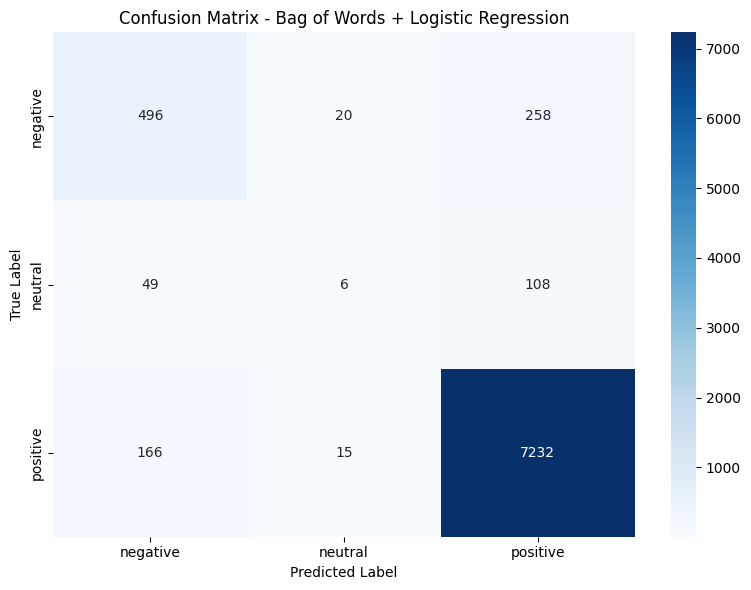

In [38]:
# 1. Bag of Words + Logistic Regression
print("\n1. Training Bag of Words + Logistic Regression...")
start_time = time.time()

bow_lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

bow_lr_pipeline.fit(X_train, y_train)
y_pred_bow_lr = bow_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_bow_lr)
report = classification_report(y_test, y_pred_bow_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_bow_lr)

print("\nBag of Words + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow_lr))

# Store results
model_results['BOW + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Bag of Words + Logistic Regression')
plt.tight_layout()
plt.show()



2. Training TF-IDF + Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training completed in 5.51 seconds

TF-IDF + Logistic Regression Results:
Accuracy: 0.9213

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.47      0.58       774
     neutral       0.00      0.00      0.00       163
    positive       0.93      0.99      0.96      7413

    accuracy                           0.92      8350
   macro avg       0.56      0.49      0.51      8350
weighted avg       0.90      0.92      0.91      8350



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

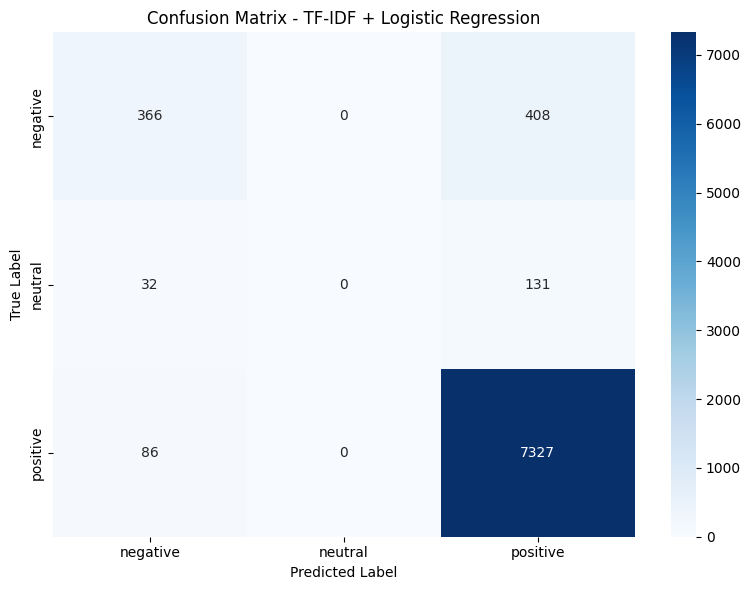

In [39]:
# 2. TF-IDF + Logistic Regression
print("\n2. Training TF-IDF + Logistic Regression...")
start_time = time.time()

tfidf_lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

tfidf_lr_pipeline.fit(X_train, y_train)
y_pred_tfidf_lr = tfidf_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_tfidf_lr)
report = classification_report(y_test, y_pred_tfidf_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_tfidf_lr)

print("\nTF-IDF + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_lr))

# Store results
model_results['TF-IDF + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.tight_layout()
plt.show()


In [40]:
# Collect results for the Naive Bayes models (if you've run them already)
# For BOW + NB
if 'bow_pipeline' in locals():
    start_time = time.time()
    bow_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_bow_nb = bow_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_bow_nb)
    report = classification_report(y_test, y_pred_bow_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_bow_nb)

    model_results['BOW + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

# For TF-IDF + NB
if 'tfidf_pipeline' in locals():
    start_time = time.time()
    tfidf_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_tfidf_nb = tfidf_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_tfidf_nb)
    report = classification_report(y_test, y_pred_tfidf_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_tfidf_nb)

    model_results['TF-IDF + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

# Also collect results for the optimized TF-IDF + NB if available
if 'tfidf_nb_model' in locals():
    model_name = 'TF-IDF + NB (Optimized)'
    start_time = time.time()
    # Use the pre-trained model if available
    y_pred = tfidf_nb_model.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    model_results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'prediction_time': predict_time
    }


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-41-143872838.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')



Model Performance Comparison:
         Model  Accuracy  F1 Score (weighted)  Training Time (s)
0     BOW + LR  0.926228             0.918503           3.618359
1  TF-IDF + LR  0.921317             0.905406           5.513515
3  TF-IDF + NB  0.908263             0.889412           4.261667
2     BOW + NB  0.893293             0.894555           1.104885


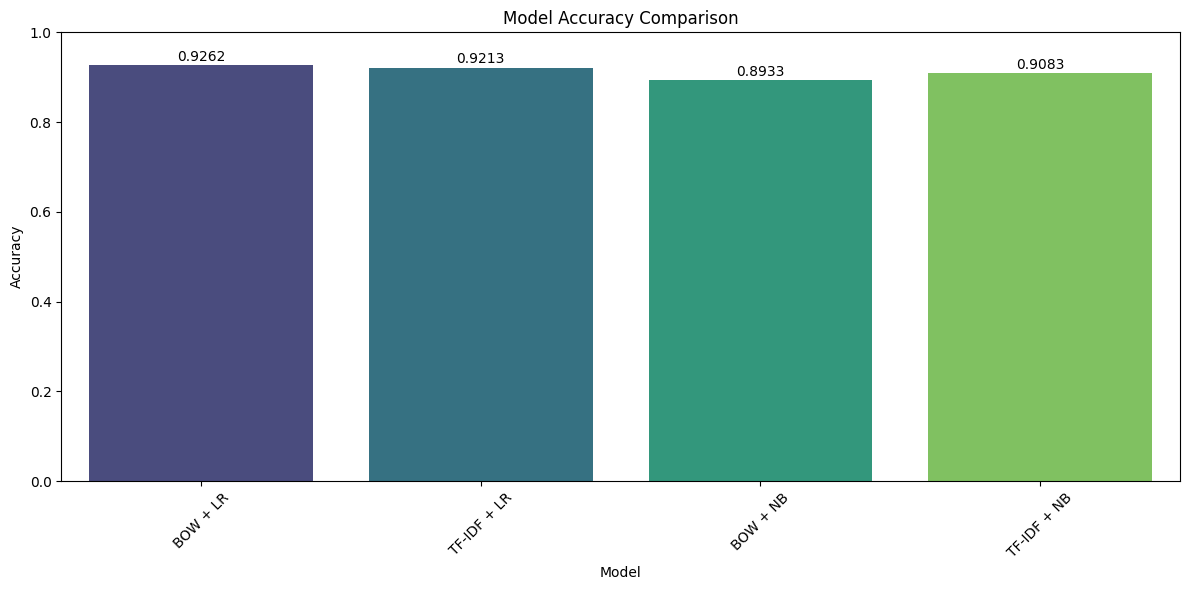

/tmp/ipython-input-41-143872838.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score (weighted)', data=comparison_df, palette='plasma')


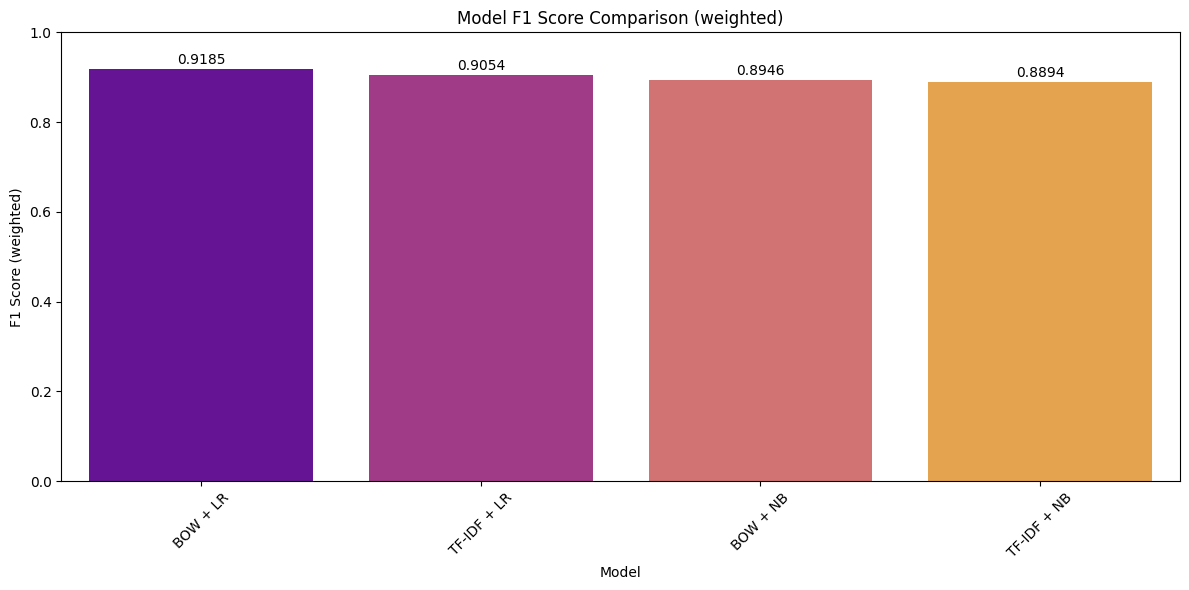

/tmp/ipython-input-41-143872838.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='rocket')


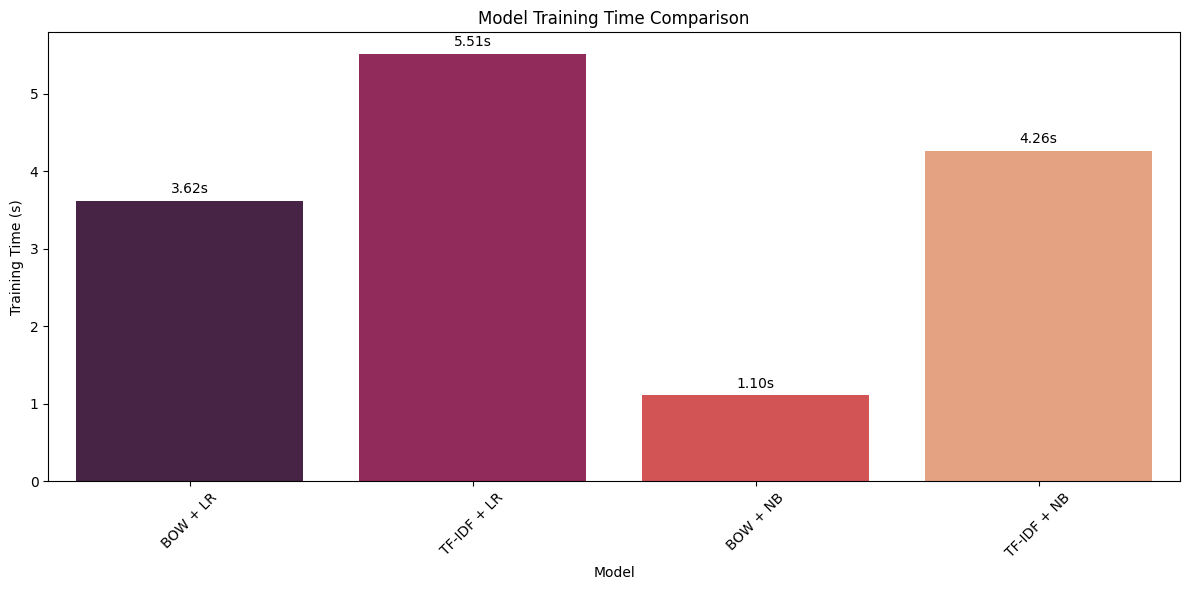

In [41]:
# Compare model performance
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
f1_weighted = [model_results[model]['report']['weighted avg']['f1-score'] for model in models]
training_times = [model_results[model].get('training_time', 0) for model in models]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score (weighted)': f1_weighted,
    'Training Time (s)': training_times
})

print("\nModel Performance Comparison:")
print(comparison_df.sort_values('Accuracy', ascending=False))

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot F1 score comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score (weighted)', data=comparison_df, palette='plasma')
plt.title('Model F1 Score Comparison (weighted)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(f1_weighted):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='rocket')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
for i, v in enumerate(training_times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center')
plt.tight_layout()
plt.show()


/tmp/ipython-input-42-1780089879.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


<Figure size 1500x1000 with 0 Axes>

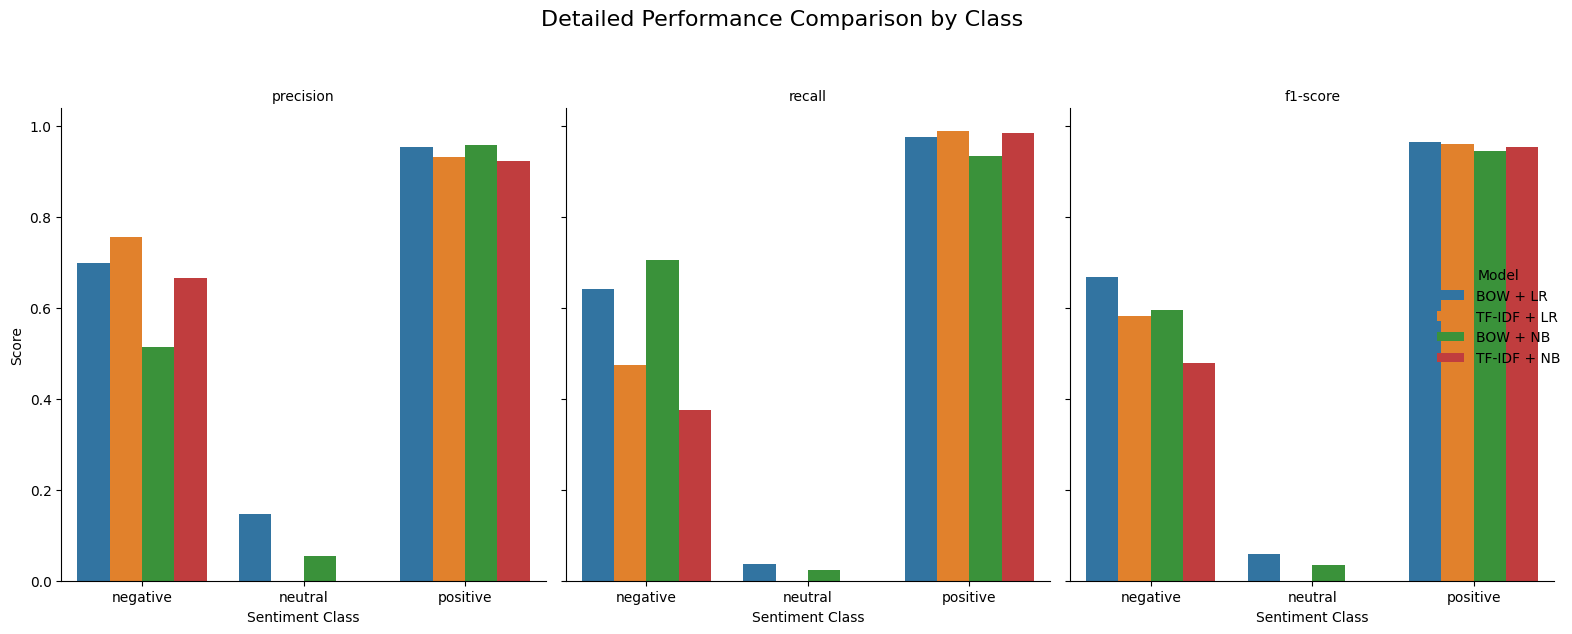

In [42]:
# Detailed class-wise performance comparison
model_metrics = {}
classes = ['negative', 'neutral', 'positive']
metrics = ['precision', 'recall', 'f1-score']

# Extract class-wise metrics for each model
for model_name, results in model_results.items():
    for cls in classes:
        if cls in results['report']:
            for metric in metrics:
                key = f"{model_name}_{cls}_{metric}"
                model_metrics[key] = results['report'][cls][metric]

# Reshape data for visualization
metrics_df = pd.DataFrame(columns=['Model', 'Class', 'Metric', 'Value'])

for model_name in models:
    for cls in classes:
        for metric in metrics:
            key = f"{model_name}_{cls}_{metric}"
            if key in model_metrics:
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Model': [model_name],
                    'Class': [cls],
                    'Metric': [metric],
                    'Value': [model_metrics[key]]
                })], ignore_index=True)

# Plot detailed comparison
plt.figure(figsize=(15, 10))
g = sns.catplot(
    data=metrics_df, x='Class', y='Value', hue='Model', col='Metric',
    kind='bar', height=6, aspect=0.8, palette='tab10', errorbar=None
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Sentiment Class", "Score")
g.fig.suptitle("Detailed Performance Comparison by Class", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


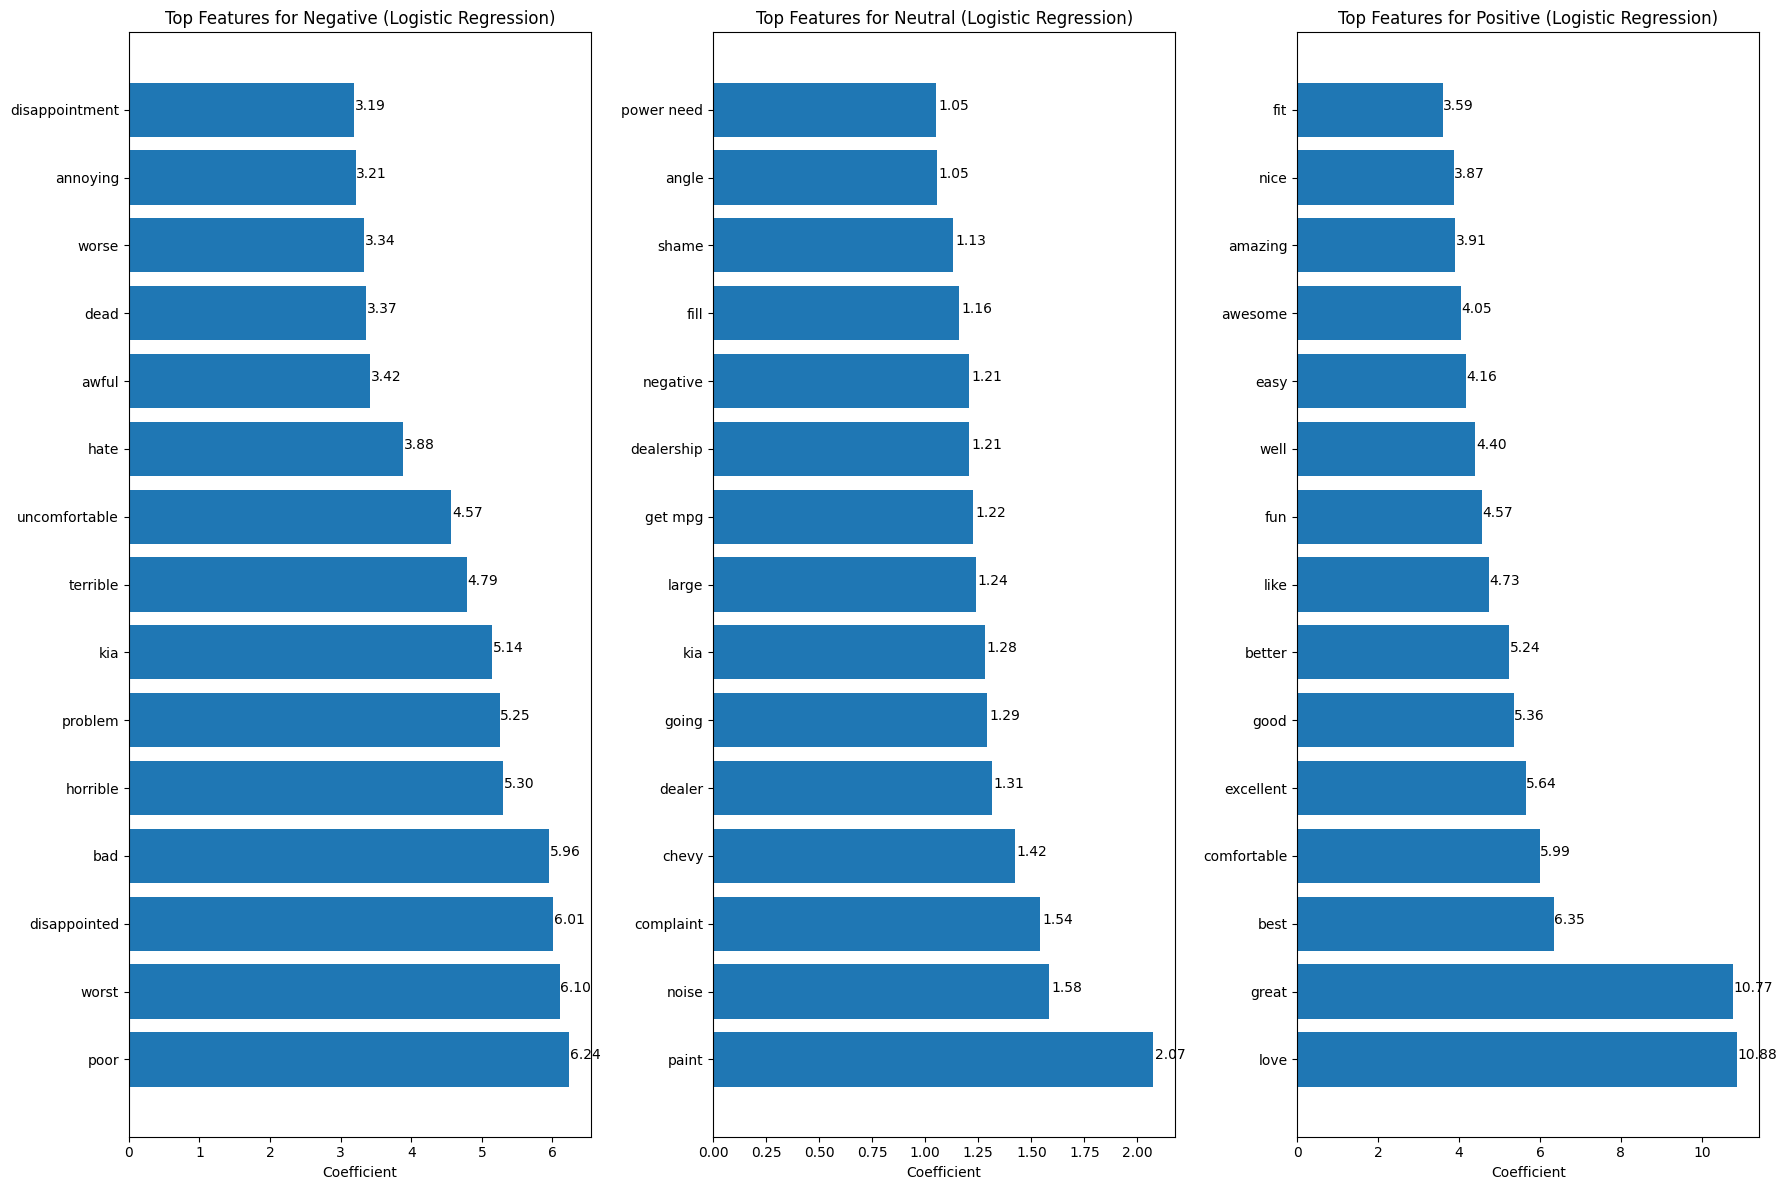

In [43]:
# Feature importance analysis for Logistic Regression
def get_top_lr_features(pipeline, label_index, n=20):
    vectorizer = pipeline.named_steps['vectorizer']
    model = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()

    # Get coefficients for the specified class
    coef = model.coef_[label_index]

    # Get top features for this class
    top_indices = np.argsort(coef)[::-1][:n]
    top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]

    return top_features

# Get feature importance for TF-IDF + LR model
sentiment_indices = {cls: idx for idx, cls in enumerate(tfidf_lr_pipeline.classes_)}
sentiments = ['negative', 'neutral', 'positive']

plt.figure(figsize=(18, 12))
for i, sentiment in enumerate(sentiments):
    idx = sentiment_indices[sentiment]
    top_features = get_top_lr_features(tfidf_lr_pipeline, idx, n=15)

    feature_names = [f[0] for f in top_features]
    coefficients = [f[1] for f in top_features]

    plt.subplot(1, 3, i+1)
    bars = plt.barh(range(len(feature_names)), coefficients, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Coefficient')
    plt.title(f'Top Features for {sentiment.capitalize()} (Logistic Regression)')

    for bar_idx, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar_idx, f"{coefficients[bar_idx]:.2f}")

plt.tight_layout()
plt.show()


In [44]:
# Error analysis: find examples where models disagree
if 'y_pred_tfidf_nb' in locals() and 'y_pred_tfidf_lr' in locals():
    # Find where NB and LR make different predictions
    disagreement_indices = np.where(y_pred_tfidf_nb != y_pred_tfidf_lr)[0]

    if len(disagreement_indices) > 0:
        # Create a DataFrame with the disagreements
        disagreements = pd.DataFrame({
            'Text': X_test.iloc[disagreement_indices].values,
            'True Label': y_test.iloc[disagreement_indices].values,
            'NB Prediction': y_pred_tfidf_nb[disagreement_indices],
            'LR Prediction': y_pred_tfidf_lr[disagreement_indices]
        })

        # Calculate where each model was correct
        disagreements['NB Correct'] = disagreements['NB Prediction'] == disagreements['True Label']
        disagreements['LR Correct'] = disagreements['LR Prediction'] == disagreements['True Label']

        # Print summary
        print("\nDisagreement Analysis:")
        print(f"Total examples where TF-IDF+NB and TF-IDF+LR disagree: {len(disagreements)}")
        print(f"TF-IDF+NB correct but TF-IDF+LR wrong: {sum(disagreements['NB Correct'] & ~disagreements['LR Correct'])}")
        print(f"TF-IDF+LR correct but TF-IDF+NB wrong: {sum(~disagreements['NB Correct'] & disagreements['LR Correct'])}")
        print(f"Both wrong but different predictions: {sum(~disagreements['NB Correct'] & ~disagreements['LR Correct'])}")

        # Print some examples
        print("\nSample disagreements (first 5):")
        for i, (idx, row) in enumerate(disagreements.head(5).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"Text: {row['Text'][:150]}...")
            print(f"True label: {row['True Label']}")
            print(f"NB prediction: {row['NB Prediction']} (Correct: {row['NB Correct']})")
            print(f"LR prediction: {row['LR Prediction']} (Correct: {row['LR Correct']})")
            print("-" * 80)


Disagreement Analysis:
Total examples where TF-IDF+NB and TF-IDF+LR disagree: 250
TF-IDF+NB correct but TF-IDF+LR wrong: 64
TF-IDF+LR correct but TF-IDF+NB wrong: 173
Both wrong but different predictions: 13

Sample disagreements (first 5):

Example 1:
Text: great car performance wise except constant loud squealing brake dealership refuse fix problem amg respnd inquiry called e squeeler...
True label: positive
NB prediction: negative (Correct: False)
LR prediction: positive (Correct: True)
--------------------------------------------------------------------------------

Example 2:
Text: bought truck dodge feb dealer shop time speak turned lawyer lemon law waiting see court going going bankrupt truck run great slam fuel jerkes time mat...
True label: neutral
NB prediction: negative (Correct: False)
LR prediction: positive (Correct: False)
--------------------------------------------------------------------------------

Example 3:
Text: traded expedition taurus x felt like needed better

In [45]:
# RoBERTa model implementation with hyperparameter tuning
!pip install transformers torch datasets scikit-learn optuna accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitl

In [46]:
!pip install --upgrade transformers

In [63]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset
from tqdm.auto import tqdm
import optuna
from optuna.pruners import MedianPruner
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('mps' if torch.mps.is_available() else 'cuda')
print(f"Using device: {device}")


Using device: cuda


In [64]:
# Prepare data for RoBERTa
print("Preparing data for RoBERTa...")

# Map string labels to integers for RoBERTa
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {v: k for k, v in id2label.items()}

# Ensure we're using the same data as before
# Use cleaned text for better results
X = df_enriched['cleaned_text']
# Get sentiment labels
y = df_enriched['sentiment_label'].map(label_map)

# Remove rows with empty text or NaN values
valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

# Use the same train/test split for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create validation set from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train_final)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Preparing data for RoBERTa...
Training set: 30058 samples
Validation set: 3340 samples
Test set: 8350 samples


In [65]:
# Create Hugging Face datasets
def convert_to_dataset(texts, labels):
    return Dataset.from_dict({
        'text': texts.tolist(),
        'label': labels.tolist()
    })

# Convert to HF Dataset format
train_dataset = convert_to_dataset(X_train_final, y_train_final)
val_dataset = convert_to_dataset(X_val, y_val)
test_dataset = convert_to_dataset(X_test, y_test)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

# Apply tokenization to datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    report = classification_report(
        labels,
        predictions,
        target_names=['negative', 'neutral', 'positive'],
        output_dict=True
    )

    return {
        'accuracy': accuracy,
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall']
    }


Map:   0%|          | 0/30058 [00:00<?, ? examples/s]

Map:   0%|          | 0/3340 [00:00<?, ? examples/s]

Map:   0%|          | 0/8350 [00:00<?, ? examples/s]

In [66]:
# Basic training function without hyperparameter tuning
def train_roberta(learning_rate=2e-5, batch_size=16, num_epochs=3, weight_decay=0.01):
    # Load pretrained model
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./roberta_sentiment',
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",  # Disable wandb, tensorboard etc.
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    val_results = trainer.evaluate()

    # Evaluate on test set
    test_results = trainer.evaluate(tokenized_test)

    return model, trainer, val_results, test_results


In [51]:
# Run RoBERTa with default hyperparameters
print("Training RoBERTa with default hyperparameters...")
roberta_model, roberta_trainer, val_results, test_results = train_roberta(
    learning_rate=2e-5,
    batch_size=16,
    num_epochs=3,
    weight_decay=0.01
)

# Print results
print("\nValidation Results:")
for key, value in val_results.items():
    print(f"{key}: {value:.4f}")

print("\nTest Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Training RoBERTa with default hyperparameters...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.241700,0.212527,0.937725,0.927223,0.917500,0.937725
2,0.189000,0.207245,0.940419,0.931168,0.940136,0.940419
3,0.165500,0.218089,0.937425,0.931678,0.928201,0.937425



Validation Results:
eval_loss: 0.2072
eval_accuracy: 0.9404
eval_f1_weighted: 0.9312
eval_precision_weighted: 0.9401
eval_recall_weighted: 0.9404
eval_runtime: 6.1942
eval_samples_per_second: 539.2110
eval_steps_per_second: 33.7410
epoch: 3.0000

Test Results:
eval_loss: 0.2155
eval_accuracy: 0.9347
eval_f1_weighted: 0.9249
eval_precision_weighted: 0.9300
eval_recall_weighted: 0.9347
eval_runtime: 15.7559
eval_samples_per_second: 529.9620
eval_steps_per_second: 33.1310
epoch: 3.0000


In [ ]:
!pip install plotly

In [ ]:
import plotly

In [69]:
# Define hyperparameter optimization with Optuna
def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)

    # Set fixed number of epochs for optimization
    num_epochs = 3  # Less epochs for faster optimization

    # Load pretrained model
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./roberta_trial_{trial.number}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",
        logging_steps=len(tokenized_train) // batch_size,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()

    # Return validation accuracy for optimization
    return eval_results["eval_accuracy"]


In [70]:
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction="maximize", pruner=MedianPruner())
study.optimize(objective, n_trials=10)  # Adjust n_trials based on resources

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

optuna_vis_fig = optuna.visualization.plot_param_importances(study)
optuna_vis_fig.show()

best_params = study.best_params
print("\nTraining final model with best hyperparameters...")
best_roberta_model, best_roberta_trainer, best_val_results, best_test_results = train_roberta(
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    num_epochs=3,  # Use more epochs for final model
    weight_decay=best_params['weight_decay']
)


[I 2025-06-19 08:37:07,046] A new study created in memory with name: no-name-3aae46ff-9d37-4ac7-b7f7-f33a1effdd04


Starting hyperparameter optimization with Optuna...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.286200,0.212595,0.933533,0.924464,0.915573,0.933533
2,0.231500,0.258782,0.925749,0.909361,0.903654,0.925749
3,0.204300,0.196240,0.935329,0.924242,0.914601,0.935329


[I 2025-06-19 08:45:08,002] Trial 0 finished with value: 0.9353293413173652 and parameters: {'learning_rate': 4.267039578795875e-05, 'batch_size': 32, 'weight_decay': 0.02015926779571705}. Best is trial 0 with value: 0.9353293413173652.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.252800,0.196353,0.931737,0.919675,0.910023,0.931737
2,0.187700,0.193871,0.940419,0.932190,0.939919,0.940419
3,0.163600,0.199675,0.935629,0.929284,0.926134,0.935629


[I 2025-06-19 08:53:08,663] Trial 1 finished with value: 0.9404191616766467 and parameters: {'learning_rate': 1.2026930816242509e-05, 'batch_size': 32, 'weight_decay': 0.05098572620187065}. Best is trial 1 with value: 0.9404191616766467.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.276700,0.218747,0.932036,0.921063,0.911230,0.932036
2,0.215300,0.212415,0.938323,0.927185,0.917553,0.938323
3,0.183000,0.195999,0.937725,0.928337,0.919145,0.937725


[I 2025-06-19 09:01:09,614] Trial 2 finished with value: 0.9377245508982036 and parameters: {'learning_rate': 4.0610214249115146e-05, 'batch_size': 32, 'weight_decay': 0.03222422498436199}. Best is trial 1 with value: 0.9404191616766467.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.280200,0.291528,0.938024,0.927231,0.917566,0.938024
2,0.231600,0.242532,0.940419,0.933729,0.933916,0.940419
3,0.203900,0.250956,0.938623,0.931307,0.929800,0.938623


[I 2025-06-19 09:12:04,797] Trial 3 finished with value: 0.9404191616766467 and parameters: {'learning_rate': 1.4555689357986844e-05, 'batch_size': 8, 'weight_decay': 0.045087746675554735}. Best is trial 1 with value: 0.9404191616766467.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.422800,0.429616,0.888024,0.835356,0.788587,0.888024
2,0.405300,0.404588,0.898802,0.862281,0.876927,0.898802
3,0.276700,0.238507,0.936527,0.925846,0.916081,0.936527


[I 2025-06-19 09:22:57,664] Trial 4 finished with value: 0.9365269461077844 and parameters: {'learning_rate': 3.271666800852287e-05, 'batch_size': 8, 'weight_decay': 0.03355387512475743}. Best is trial 1 with value: 0.9404191616766467.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.245000,0.207159,0.937126,0.925247,0.916095,0.937126
2,0.173400,0.180868,0.941317,0.933694,0.934752,0.941317
3,0.137800,0.198430,0.939521,0.933373,0.930359,0.939521


[I 2025-06-19 09:30:58,345] Trial 5 finished with value: 0.9413173652694611 and parameters: {'learning_rate': 3.4950529818898764e-05, 'batch_size': 32, 'weight_decay': 0.04144496075241205}. Best is trial 5 with value: 0.9413173652694611.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.334600,0.286900,0.926347,0.910705,0.904009,0.926347
2,0.262700,0.248355,0.932036,0.923314,0.914804,0.932036
3,0.238000,0.244409,0.937126,0.926872,0.917187,0.937126


[I 2025-06-19 09:41:49,322] Trial 6 finished with value: 0.937125748502994 and parameters: {'learning_rate': 2.4543024799615837e-05, 'batch_size': 8, 'weight_decay': 0.04433947840320675}. Best is trial 5 with value: 0.9413173652694611.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.278200,0.276826,0.936527,0.927160,0.929703,0.936527
2,0.224800,0.230381,0.938922,0.930386,0.939770,0.938922
3,0.200500,0.264974,0.936826,0.929974,0.928838,0.936826


[I 2025-06-19 09:52:42,575] Trial 7 finished with value: 0.9389221556886228 and parameters: {'learning_rate': 1.3766172027853934e-05, 'batch_size': 8, 'weight_decay': 0.02837539994683419}. Best is trial 5 with value: 0.9413173652694611.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.258400,0.205864,0.937425,0.927940,0.918670,0.937425
2,0.195800,0.191175,0.939521,0.931165,0.941622,0.939521
3,0.163500,0.191495,0.940120,0.934160,0.934693,0.940120


[I 2025-06-19 10:00:43,453] Trial 8 finished with value: 0.9395209580838323 and parameters: {'learning_rate': 3.487769571104178e-05, 'batch_size': 32, 'weight_decay': 0.09531606826212076}. Best is trial 5 with value: 0.9413173652694611.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.267400,0.215865,0.934431,0.923851,0.914074,0.934431
2,0.217600,0.245840,0.933832,0.923563,0.913858,0.933832
3,0.183800,0.215287,0.934132,0.927179,0.923665,0.934132


[I 2025-06-19 10:09:41,048] Trial 9 finished with value: 0.9341317365269461 and parameters: {'learning_rate': 1.9839044418194953e-05, 'batch_size': 16, 'weight_decay': 0.052430136248004626}. Best is trial 5 with value: 0.9413173652694611.


Best trial:
  Value: 0.9413173652694611
  Params: 
    learning_rate: 3.4950529818898764e-05
    batch_size: 32
    weight_decay: 0.04144496075241205



Training final model with best hyperparameters...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.268100,0.207159,0.937126,0.925247,0.916095,0.937126
2,0.173300,0.180868,0.941317,0.933694,0.934752,0.941317
3,0.141600,0.198430,0.939521,0.933373,0.930359,0.939521



Detailed evaluation of RoBERTa model...



Classification Report:
              precision    recall  f1-score      support
negative       0.742489  0.670543  0.704684   774.000000
neutral        0.800000  0.024540  0.047619   163.000000
positive       0.952393  0.982328  0.967129  7413.000000
accuracy       0.934731  0.934731  0.934731     0.934731
macro avg      0.831628  0.559137  0.573144  8350.000000
weighted avg   0.929962  0.934731  0.924852  8350.000000


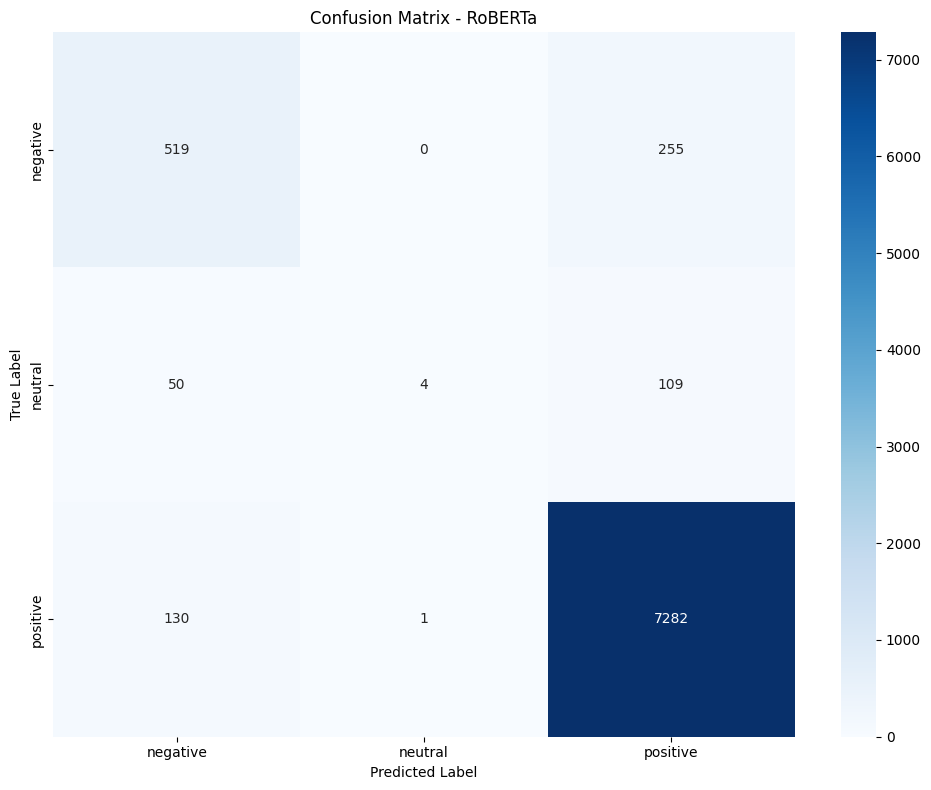

In [71]:
# Detailed evaluation of RoBERTa model on test set
def detailed_roberta_evaluation(trainer, dataset):
    # Get predictions
    predictions = trainer.predict(dataset)

    # Extract predictions and labels
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Generate classification report
    report = classification_report(
        labels, preds,
        target_names=['negative', 'neutral', 'positive'],
        output_dict=True
    )

    # Convert report to DataFrame for easier visualization
    report_df = pd.DataFrame(report).transpose()

    # Generate confusion matrix
    cm = confusion_matrix(labels, preds)

    return preds, labels, report_df, cm

print("\nDetailed evaluation of RoBERTa model...")
roberta_preds, roberta_labels, roberta_report_df, roberta_cm = detailed_roberta_evaluation(
    roberta_trainer, tokenized_test
)

# Print classification report
print("\nClassification Report:")
print(roberta_report_df)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    roberta_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RoBERTa')
plt.tight_layout()
plt.show()


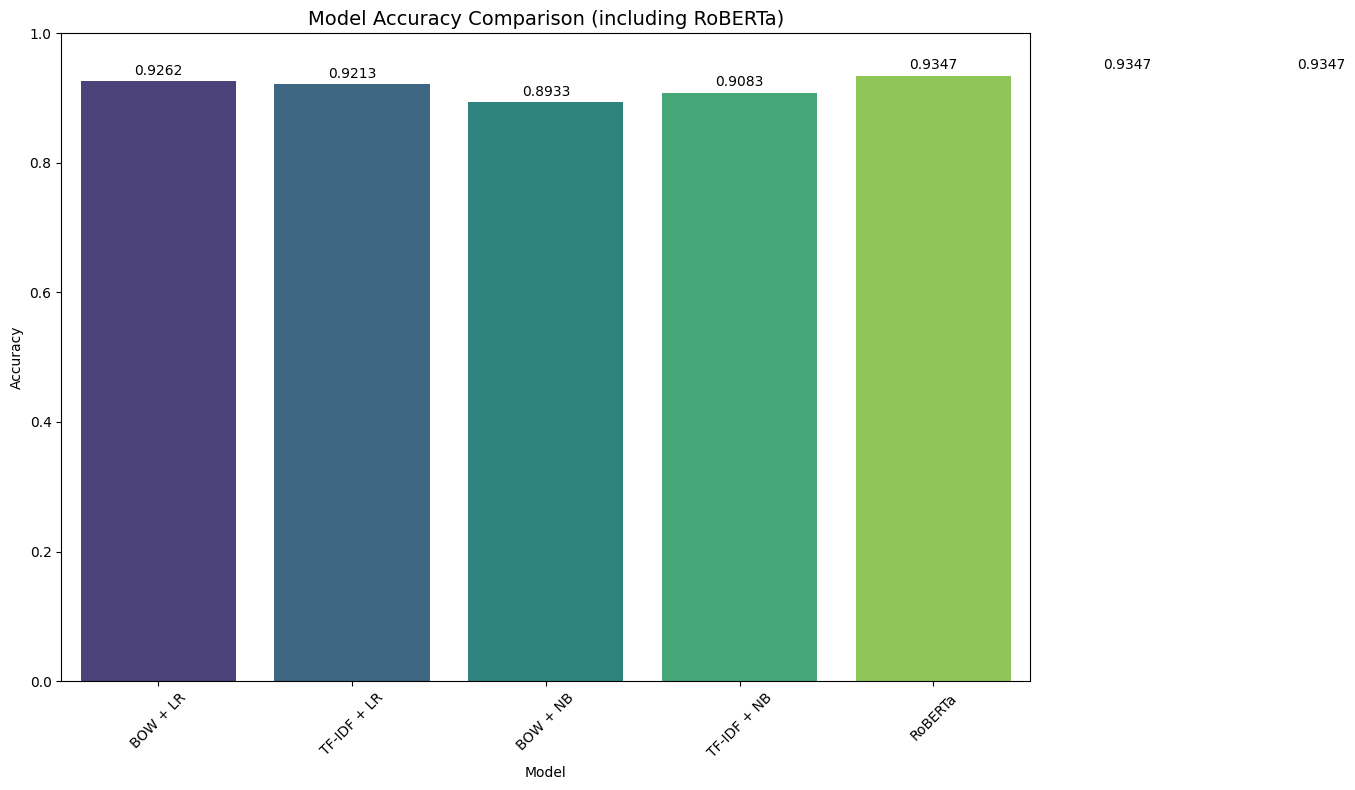

In [72]:
# Compare RoBERTa with previous models (Naive Bayes, Logistic Regression)
# Add RoBERTa results to comparison DataFrame
roberta_accuracy = accuracy_score(roberta_labels, roberta_preds)
roberta_f1 = roberta_report_df.loc['weighted avg', 'f1-score']

# Add to comparison DataFrame
new_row = pd.DataFrame({
    'Model': ['RoBERTa'],
    'Accuracy': [roberta_accuracy],
    'F1 Score (weighted)': [roberta_f1],
    'Training Time (s)': [None]  # We don't track this for RoBERTa in this notebook
})

# Concatenate with previous comparison DataFrame
comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

# Plot updated comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison (including RoBERTa)', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    if not pd.isna(v):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


In [73]:
# Function to get example predictions for each model
def get_example_predictions(examples):
    print("Example predictions from different models:")

    # Predictions from RoBERTa
    inputs = tokenizer(examples, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        logits = roberta_model(**{k: v.to(device) for k, v in inputs.items()}).logits
    roberta_preds = torch.argmax(logits, dim=1).cpu().numpy()
    roberta_pred_labels = [id2label[pred] for pred in roberta_preds]

    # Predictions from TF-IDF + LogReg
    tfidf_lr_preds = tfidf_lr_pipeline.predict(examples)

    # Predictions from TF-IDF + NB
    tfidf_nb_preds = tfidf_pipeline.predict(examples)

    # Create a DataFrame to display results
    results_df = pd.DataFrame({
        'Example': examples,
        'RoBERTa': roberta_pred_labels,
        'TF-IDF + LogReg': tfidf_lr_preds,
        'TF-IDF + NB': tfidf_nb_preds,
    })

    return results_df

# Test on example reviews
example_reviews = [
    "This car is absolutely amazing! Great mileage, comfortable seats, and powerful engine.",
    "The car is okay. Nothing special but gets the job done.",
    "Worst car ever! Broke down three times in the first month. Avoid at all costs!",
    "Not bad for the price, but I expected more from this brand. Average performance.",
    "The interior is comfortable, but the engine is noisy and the fuel economy is terrible."
]

example_predictions_df = get_example_predictions(example_reviews)
print(example_predictions_df)


Example predictions from different models:
                                             Example   RoBERTa  \
0  This car is absolutely amazing! Great mileage,...  positive   
1  The car is okay. Nothing special but gets the ...  positive   
2  Worst car ever! Broke down three times in the ...  negative   
3  Not bad for the price, but I expected more fro...  positive   
4  The interior is comfortable, but the engine is...  negative   

  TF-IDF + LogReg TF-IDF + NB  
0        positive    positive  
1        positive    positive  
2        negative    negative  
3        negative    positive  
4        negative    positive  


In [74]:
# Save the best RoBERTa model (uncomment if you ran hyperparameter tuning)
best_roberta_trainer.save_model("./best_roberta_sentiment")

# You can load the model later with:
loaded_model = RobertaForSequenceClassification.from_pretrained("./best_roberta_sentiment")
